In [250]:
import numpy as np
import mne

# Importing RAW Data from MNE Dataset 

In [274]:
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = (
    sample_data_folder / "MEG" / "sample" / "sample_audvis_filt-0-40_raw.fif" #filtered and downsampled version of the data 
)
# unfiltered version "sample_audvis_raw.fif"
raw = mne.io.read_raw_fif(sample_data_raw_file)
X_all = raw.get_data()
len(X_all) # chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus, 60 EEG, 1 EOG: 204+102+9+60+1=376

Opening raw data file C:\Users\yonau\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


376

In [275]:
print(raw)
print(raw.info)
print(raw.info['ch_names'])

<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~3.2 MB, data not loaded>
<Info | 15 non-empty values
 bads: 2 items (MEG 2443, EEG 053)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus, 60 EEG, 1 EOG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 376
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off, Average EEG reference: off
 sfreq: 150.2 Hz
>
['MEG 0113', 'MEG 0112', 'MEG 0111', 'MEG 0122', 'MEG 0123', 'MEG 0121', 'MEG 0132', 'MEG 0133', 'MEG 0131', 'MEG 0143', 'MEG 0142', 'MEG 0141', 'MEG 0213', 'MEG 0212', 'MEG 0211', 'MEG 0222', 'MEG 0223', 'MEG 0221', 'MEG 0232', 'MEG 0233', 'MEG 0231', 'MEG 0243', 'MEG 0242', 'MEG 0241', 'MEG 031

Let's choose some channels to display

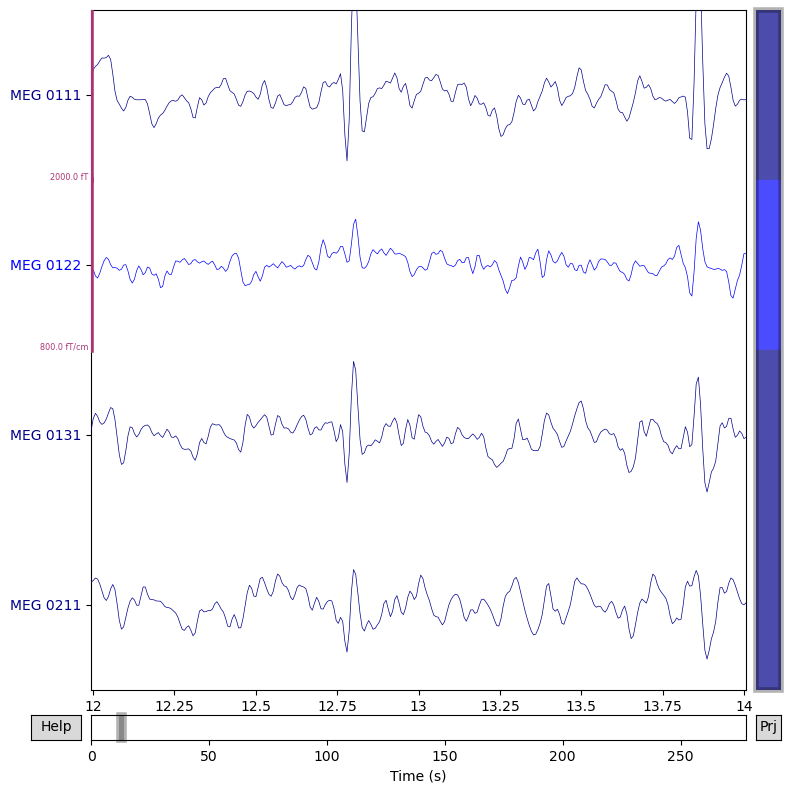

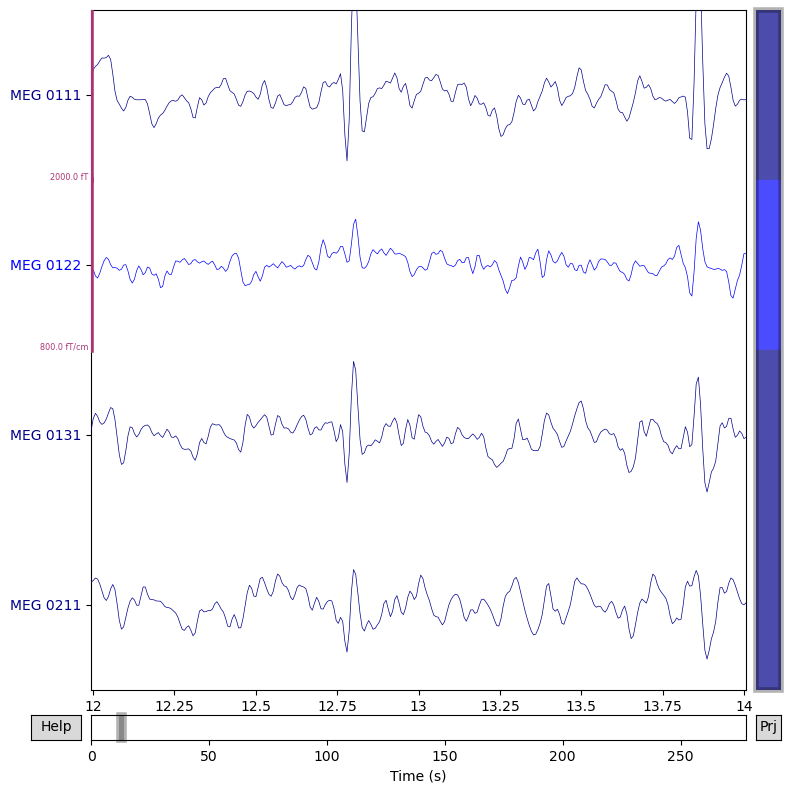

In [276]:
sfreq = 150
raw2 = raw.copy() #make a copy, otherwise raw is also modified 
chs = [
    "MEG 0111",
    "MEG 0122",
    "MEG 0131",
    "MEG 0211",
]
chan_idxs = [raw2.ch_names.index(ch) for ch in chs]
raw2.plot(order=chan_idxs, start=12, duration=2)

# I. Univariate Convolutional Sparse Coding

## 1. Comparison of filtred data and unfiltred data 

We choose one channel to apply CSC on, it is MEG 0111

### Unfiltered Data MEG

In [254]:
import matplotlib.pyplot as plt

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Removing projector <Projection | Average EEG reference, active : False, n_channels : 60>
[[ 2.41390174e-15  1.71297955e-14  4.07182140e-14 ... -4.17630201e-14
  -5.12135393e-13 -7.30746532e-13]]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


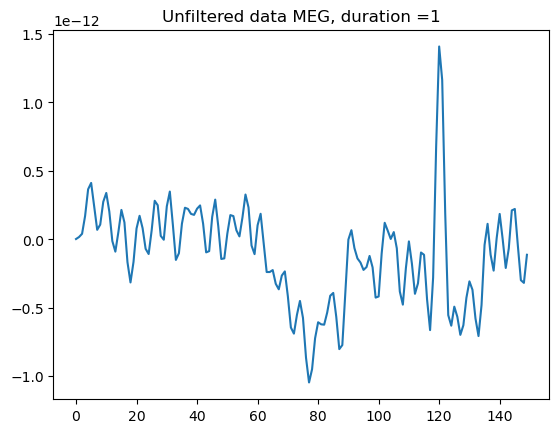

In [277]:
print(raw2.pick_channels(ch_names= ["MEG 0111"])[:][0])
X_unfiltered = raw2.pick_channels(ch_names= ["MEG 0111"])[:][0].astype(np.float64)
plt.plot(X_unfiltered[0][0:150])
plt.title("Unfiltered data MEG, duration =1")
plt.show()

### Filtered Data MEG

Applying a filter on raw data as advised in https://alphacsc.github.io/stable/auto_examples/csc/plot_lfp_data.html#sphx-glr-auto-examples-csc-plot-lfp-data-py, it is a convenient function from MNE.


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Setting up band-pass filter from 7 - 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 72.50 Hz)
- Filter length: 249 samples (1.660 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


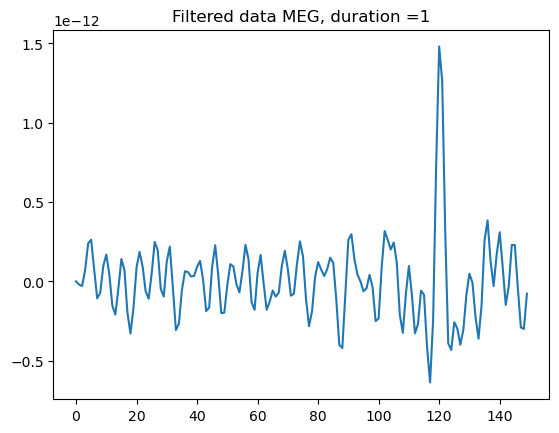

In [278]:
from mne.filter import filter_data
X_filtered = filter_data(
    raw2.pick_channels(ch_names= ["MEG 0111"])[:][0]
    .astype(np.float64), sfreq=150, l_freq=7, h_freq=70, fir_design='firwin'
                    ) #to numpy array to facilitate the plot 
plt.plot(X_filtered[0][0:150])
plt.title("Filtered data MEG, duration =1")
plt.show()

## 2. Comparison of atom extraction with CSC for filtred data and unfiltred data 

Let's define the parameters of the model with respect some parameters given in the paper 

In [279]:
reg = 1.0
n_times = 2500
n_times_atom = int(round(sfreq * 1.0))  #The support of the atom, fixed according to the paper 
n_trials = 100
n_atoms = 2 # K, the number of atoms to learn.
n_iter = 60
random_state = 10
overlap = 0

### Unfiltered Data MEG

In [280]:
starts = np.arange(0, X.shape[1] - n_times, n_times - overlap)
stops = np.arange(n_times, X.shape[1], n_times - overlap)

XUF_new = []
for idx, (start, stop) in enumerate(zip(starts, stops)):
    if idx >= n_trials:
        break
    XUF_new.append(X_unfiltered[0, start:stop])
XUF_new = np.vstack(XUF_new)
del X_unfiltered

In [281]:
XUF_new -= np.mean(XUF_new)
XUF_new /= np.std(XUF_new)

In [282]:
from numpy import hamming

In [283]:
XUF_new *= hamming(n_times)[None, :]

In [284]:
from alphacsc import learn_d_z

In [285]:
pobj, times, d_hat_UF, z_hat_UF, reg = learn_d_z(XUF_new, n_atoms, n_times_atom,
                                           reg=reg, n_iter=n_iter,
                                           random_state=random_state, n_jobs=1)

Coordinate descent loop 0 / 60 [n_jobs=1]
[seed 10] Objective (z_hat) : 7057.57886005
Using method dual for projection
[seed 10] Objective (d) 6231.75458037
Coordinate descent loop 1 / 60 [n_jobs=1]
[seed 10] Objective (z_hat) : 3877.32014953
Using method dual for projection
[seed 10] Objective (d) 3873.20048085
Coordinate descent loop 2 / 60 [n_jobs=1]
[seed 10] Objective (z_hat) : 3822.47165249
Using method dual for projection
[seed 10] Objective (d) 3817.69133033
Coordinate descent loop 3 / 60 [n_jobs=1]
[seed 10] Objective (z_hat) : 3751.37973986
Using method dual for projection
[seed 10] Objective (d) 3743.83916067
Coordinate descent loop 4 / 60 [n_jobs=1]
[seed 10] Objective (z_hat) : 3680.30074098
Using method dual for projection
[seed 10] Objective (d) 3669.32165780
Coordinate descent loop 5 / 60 [n_jobs=1]
[seed 10] Objective (z_hat) : 3595.17717872
Using method dual for projection
[seed 10] Objective (d) 3587.05333362
Coordinate descent loop 6 / 60 [n_jobs=1]
[seed 10] Object

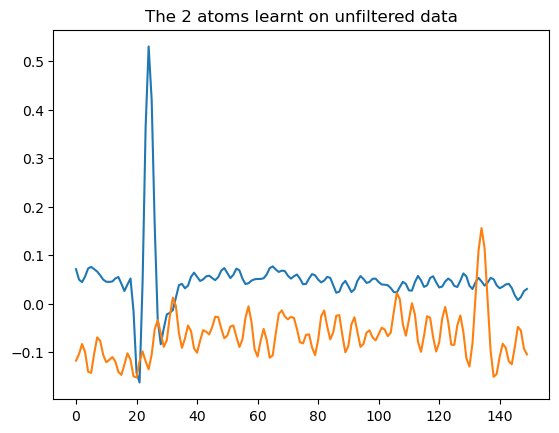

In [264]:
plt.figure()
plt.plot(d_hat_UF.T)
plt.title('The %s atoms learnt on unfiltered data'%(n_atoms))
plt.savefig('The %s atoms learnt on unfiltered data.png'%(n_atoms), bbox_inches='tight')
plt.show()

### Filtered Data MEG

In [265]:
starts = np.arange(0, X.shape[1] - n_times, n_times - overlap)
stops = np.arange(n_times, X.shape[1], n_times - overlap)

XF_new = []
for idx, (start, stop) in enumerate(zip(starts, stops)):
    if idx >= n_trials:
        break
    XF_new.append(X_filtered[0, start:stop])
XF_new = np.vstack(XF_new)
del X_filtered

In [266]:
XF_new -= np.mean(XF_new)
XF_new /= np.std(XF_new)

In [267]:
XF_new *= hamming(n_times)[None, :]

In [268]:
pobj, times, d_hat_F, z_hat_F, reg = learn_d_z(XF_new, n_atoms, n_times_atom,
                                           reg=reg, n_iter=n_iter,
                                           random_state=random_state, n_jobs=1)

Coordinate descent loop 0 / 60 [n_jobs=1]
[seed 10] Objective (z_hat) : 7763.77528195
Using method dual for projection
[seed 10] Objective (d) 7509.45862412
Coordinate descent loop 1 / 60 [n_jobs=1]
[seed 10] Objective (z_hat) : 7078.74178586
Using method dual for projection
[seed 10] Objective (d) 7063.89151809
Coordinate descent loop 2 / 60 [n_jobs=1]
[seed 10] Objective (z_hat) : 6695.42559915
Using method dual for projection
[seed 10] Objective (d) 6687.56646308
Coordinate descent loop 3 / 60 [n_jobs=1]
[seed 10] Objective (z_hat) : 6380.66884180
Using method dual for projection
[seed 10] Objective (d) 6371.76393318
Coordinate descent loop 4 / 60 [n_jobs=1]
[seed 10] Objective (z_hat) : 6111.21643588
Using method dual for projection
[seed 10] Objective (d) 6100.47206910
Coordinate descent loop 5 / 60 [n_jobs=1]
[seed 10] Objective (z_hat) : 5872.42067990
Using method dual for projection
[seed 10] Objective (d) 5860.09086190
Coordinate descent loop 6 / 60 [n_jobs=1]
[seed 10] Object

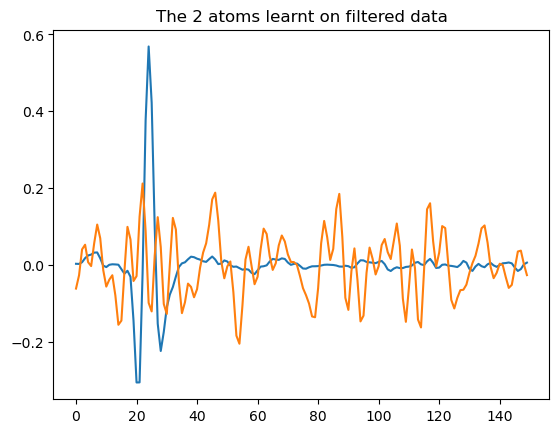

In [269]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(d_hat_F.T)
plt.title('The %s atoms learnt on filtered data'%(n_atoms))
plt.savefig('The %s atoms learnt on filtered data.png'%(n_atoms), bbox_inches='tight')
plt.show()

One can vary the number of atoms in the dictionaries, as explained in the article. But for K= 8, the extracted atoms present an overlap, it is not an optimal model. n_atoms = 2 seems to be correct. 

# II. Multivariate Convolutional Sparse Coding

Effective window size : 13.639 (s)


C:\Users\yonau\anaconda3\Lib\site-packages\mne\viz\utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


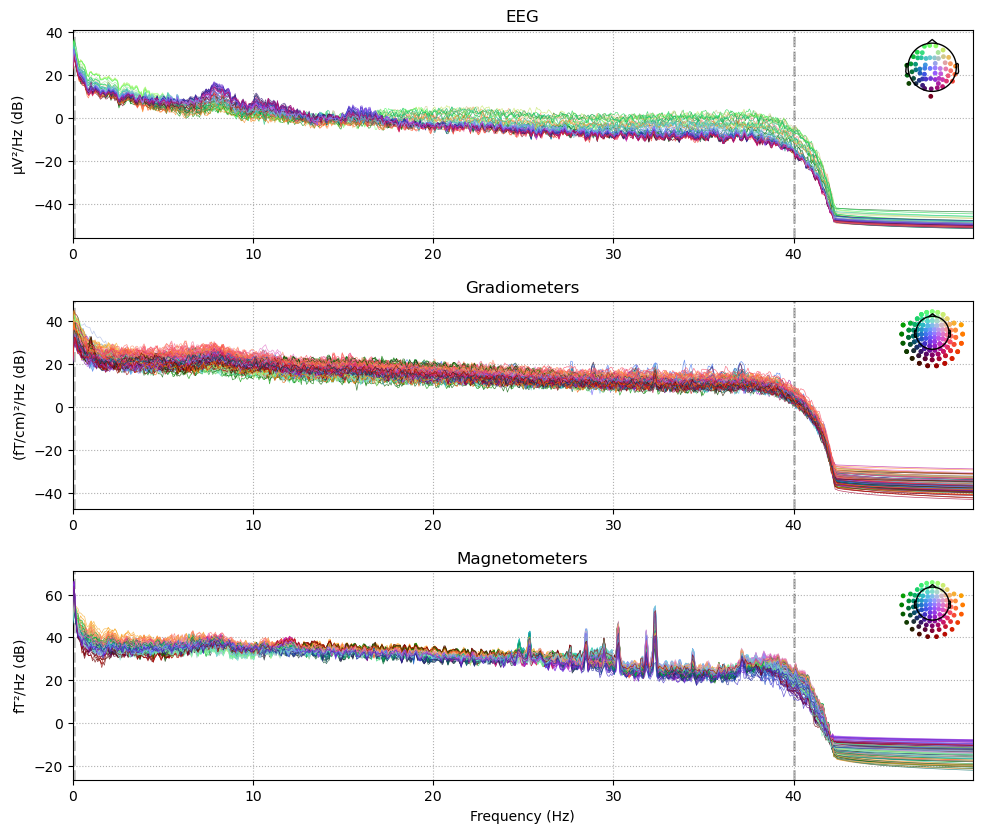

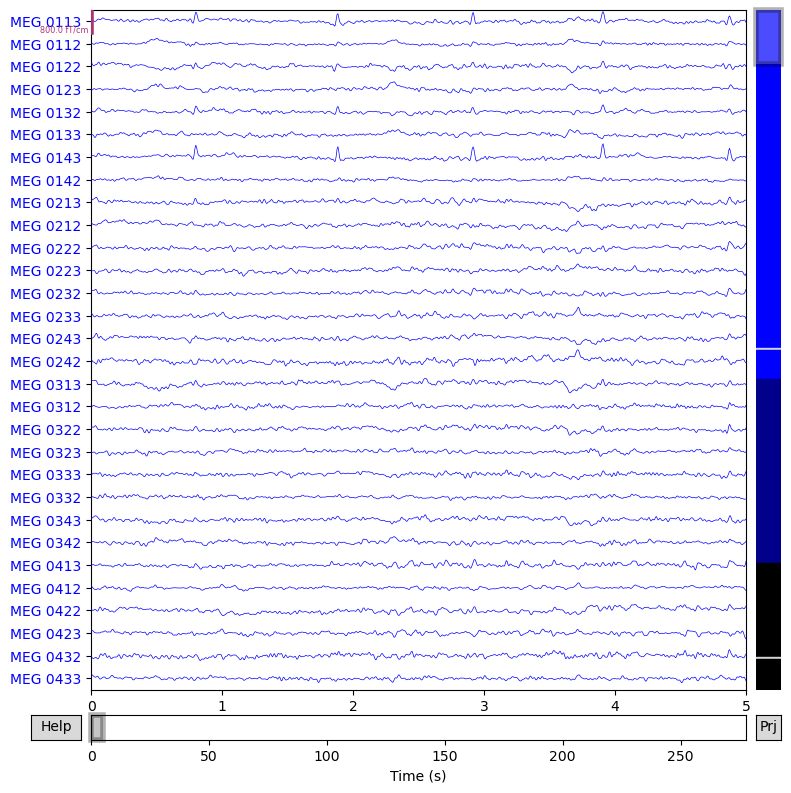

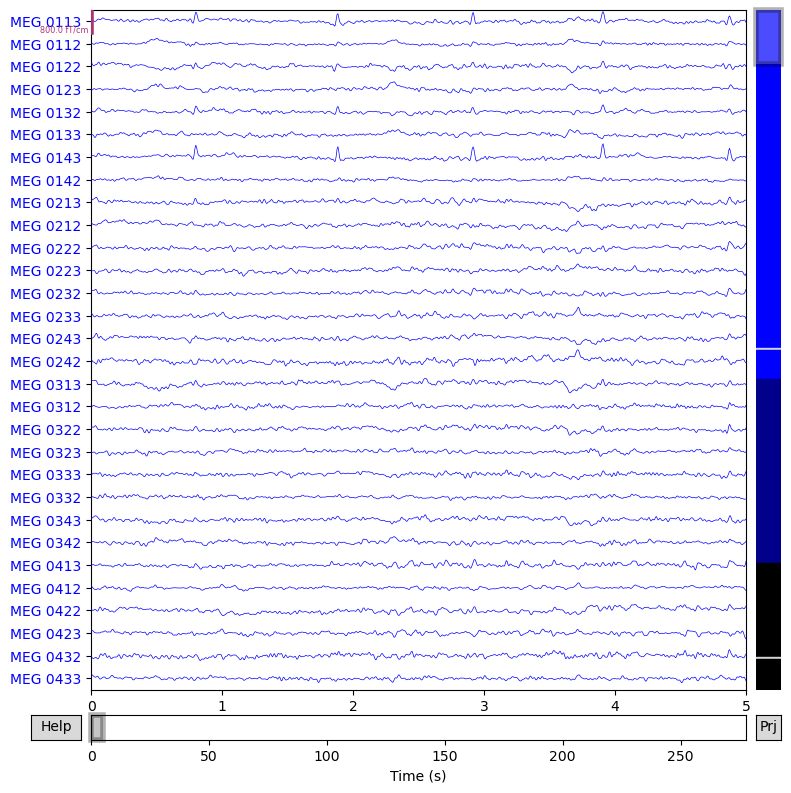

In [286]:
raw.compute_psd(fmax=50).plot(picks="data", exclude="bads")
raw.plot(duration=5, n_channels=30)

In [287]:
original_raw = raw.copy() # make a copy of the original data, otherwise raw is also modified 
MEG = original_raw.pick("meg") # pick only MEG channels, then MEG only has MEG channels
original_raw = raw.copy() # make a copy of the original data
EEG = original_raw.pick("eeg") # pick only EEG channels
type(MEG)
len(MEG[:][0])

Removing projector <Projection | Average EEG reference, active : False, n_channels : 60>
Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>


306

In [288]:
sfreq = 150.

# Define the shape of the dictionary
n_atoms = 25
n_times_atom = int(round(sfreq * 1.0))  # 1000. ms

In [289]:
MEG_reshaped = MEG[:][0].reshape(1, 306, 41700)
EEG_reshaped = EEG[:][0].reshape(1, 60, 41700)

In [290]:
from alphacsc import BatchCDL
cdl = BatchCDL(
    # Shape of the dictionary
    n_atoms=n_atoms,
    n_times_atom=n_times_atom,
    # Request a rank1 dictionary with unit norm temporal and spatial maps
    rank1=True, uv_constraint='separate',
    # Initialize the dictionary with random chunk from the data
    D_init='chunk',
    # rescale the regularization parameter to be 20% of lambda_max
    lmbd_max="scaled", reg=.2,
    # Number of iteration for the alternate minimization and cvg threshold
    n_iter=100, eps=1e-4,
    # solver for the z-step
    solver_z="lgcd", solver_z_kwargs={'tol': 1e-2, 'max_iter': 1000},
    # solver for the d-step
    solver_d='alternate_adaptive', solver_d_kwargs={'max_iter': 300},
    # Technical parameters
    verbose=1, random_state=0, n_jobs=6)

In [291]:
from alphacsc.datasets.mne_data import load_data
t_lim = (-2, 4)
X = raw.pick_types(meg=True, ref_meg=False).get_data()
len(X)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing projector <Projection | Average EEG reference, active : False, n_channels : 60>


305

In [292]:
print(X.shape)

(305, 41700)


In [293]:
MEG_CDL = cdl.fit(MEG_reshaped)

.............
[BatchCDL] Converged after 13 iteration, (dz, du) = 9.596e-05, 8.282e-05
[BatchCDL] Fit in 519.7s


In [294]:
EEG_CDL = cdl.fit(EEG_reshaped)

......
[BatchCDL] Converged after 6 iteration, (dz, du) = 6.652e-05, 5.495e-05
[BatchCDL] Fit in 142.3s


In [295]:
print("MEG_reshaped shape:", MEG_reshaped.shape)
print("MEG_reshaped shape:", EEG_reshaped.shape)

MEG_reshaped2 = MEG_reshaped.reshape(1, 306*41700)
print("MEG_reshaped2 shape:", MEG_reshaped2.shape)

MEG_reshaped shape: (1, 306, 41700)
MEG_reshaped shape: (1, 60, 41700)
MEG_reshaped2 shape: (1, 12760200)


In [297]:
def plot_pattern(D, n_cols=5, n_atoms=25, vmax=None, vmin=None, suptitle=None):
    """Plot the temporal pattern of the learn atom"""
    n_rows = int(np.ceil(n_atoms / float(n_cols)))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows),
                             subplot_kw={'xticks': (), 'yticks': ()})
    axes = axes.ravel()
    for ii in range(n_atoms):
        t = np.arange(D[ii].size) / sfreq
        axes[ii].plot(t, D[ii])
        axes[ii].set_title("Dictionary item #{}".format(ii))
        axes[ii].set(xlabel='Time (sec)', title='Learned temporal waveform')
        axes[ii].grid(True)
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=20)
    fig.tight_layout()
    return fig

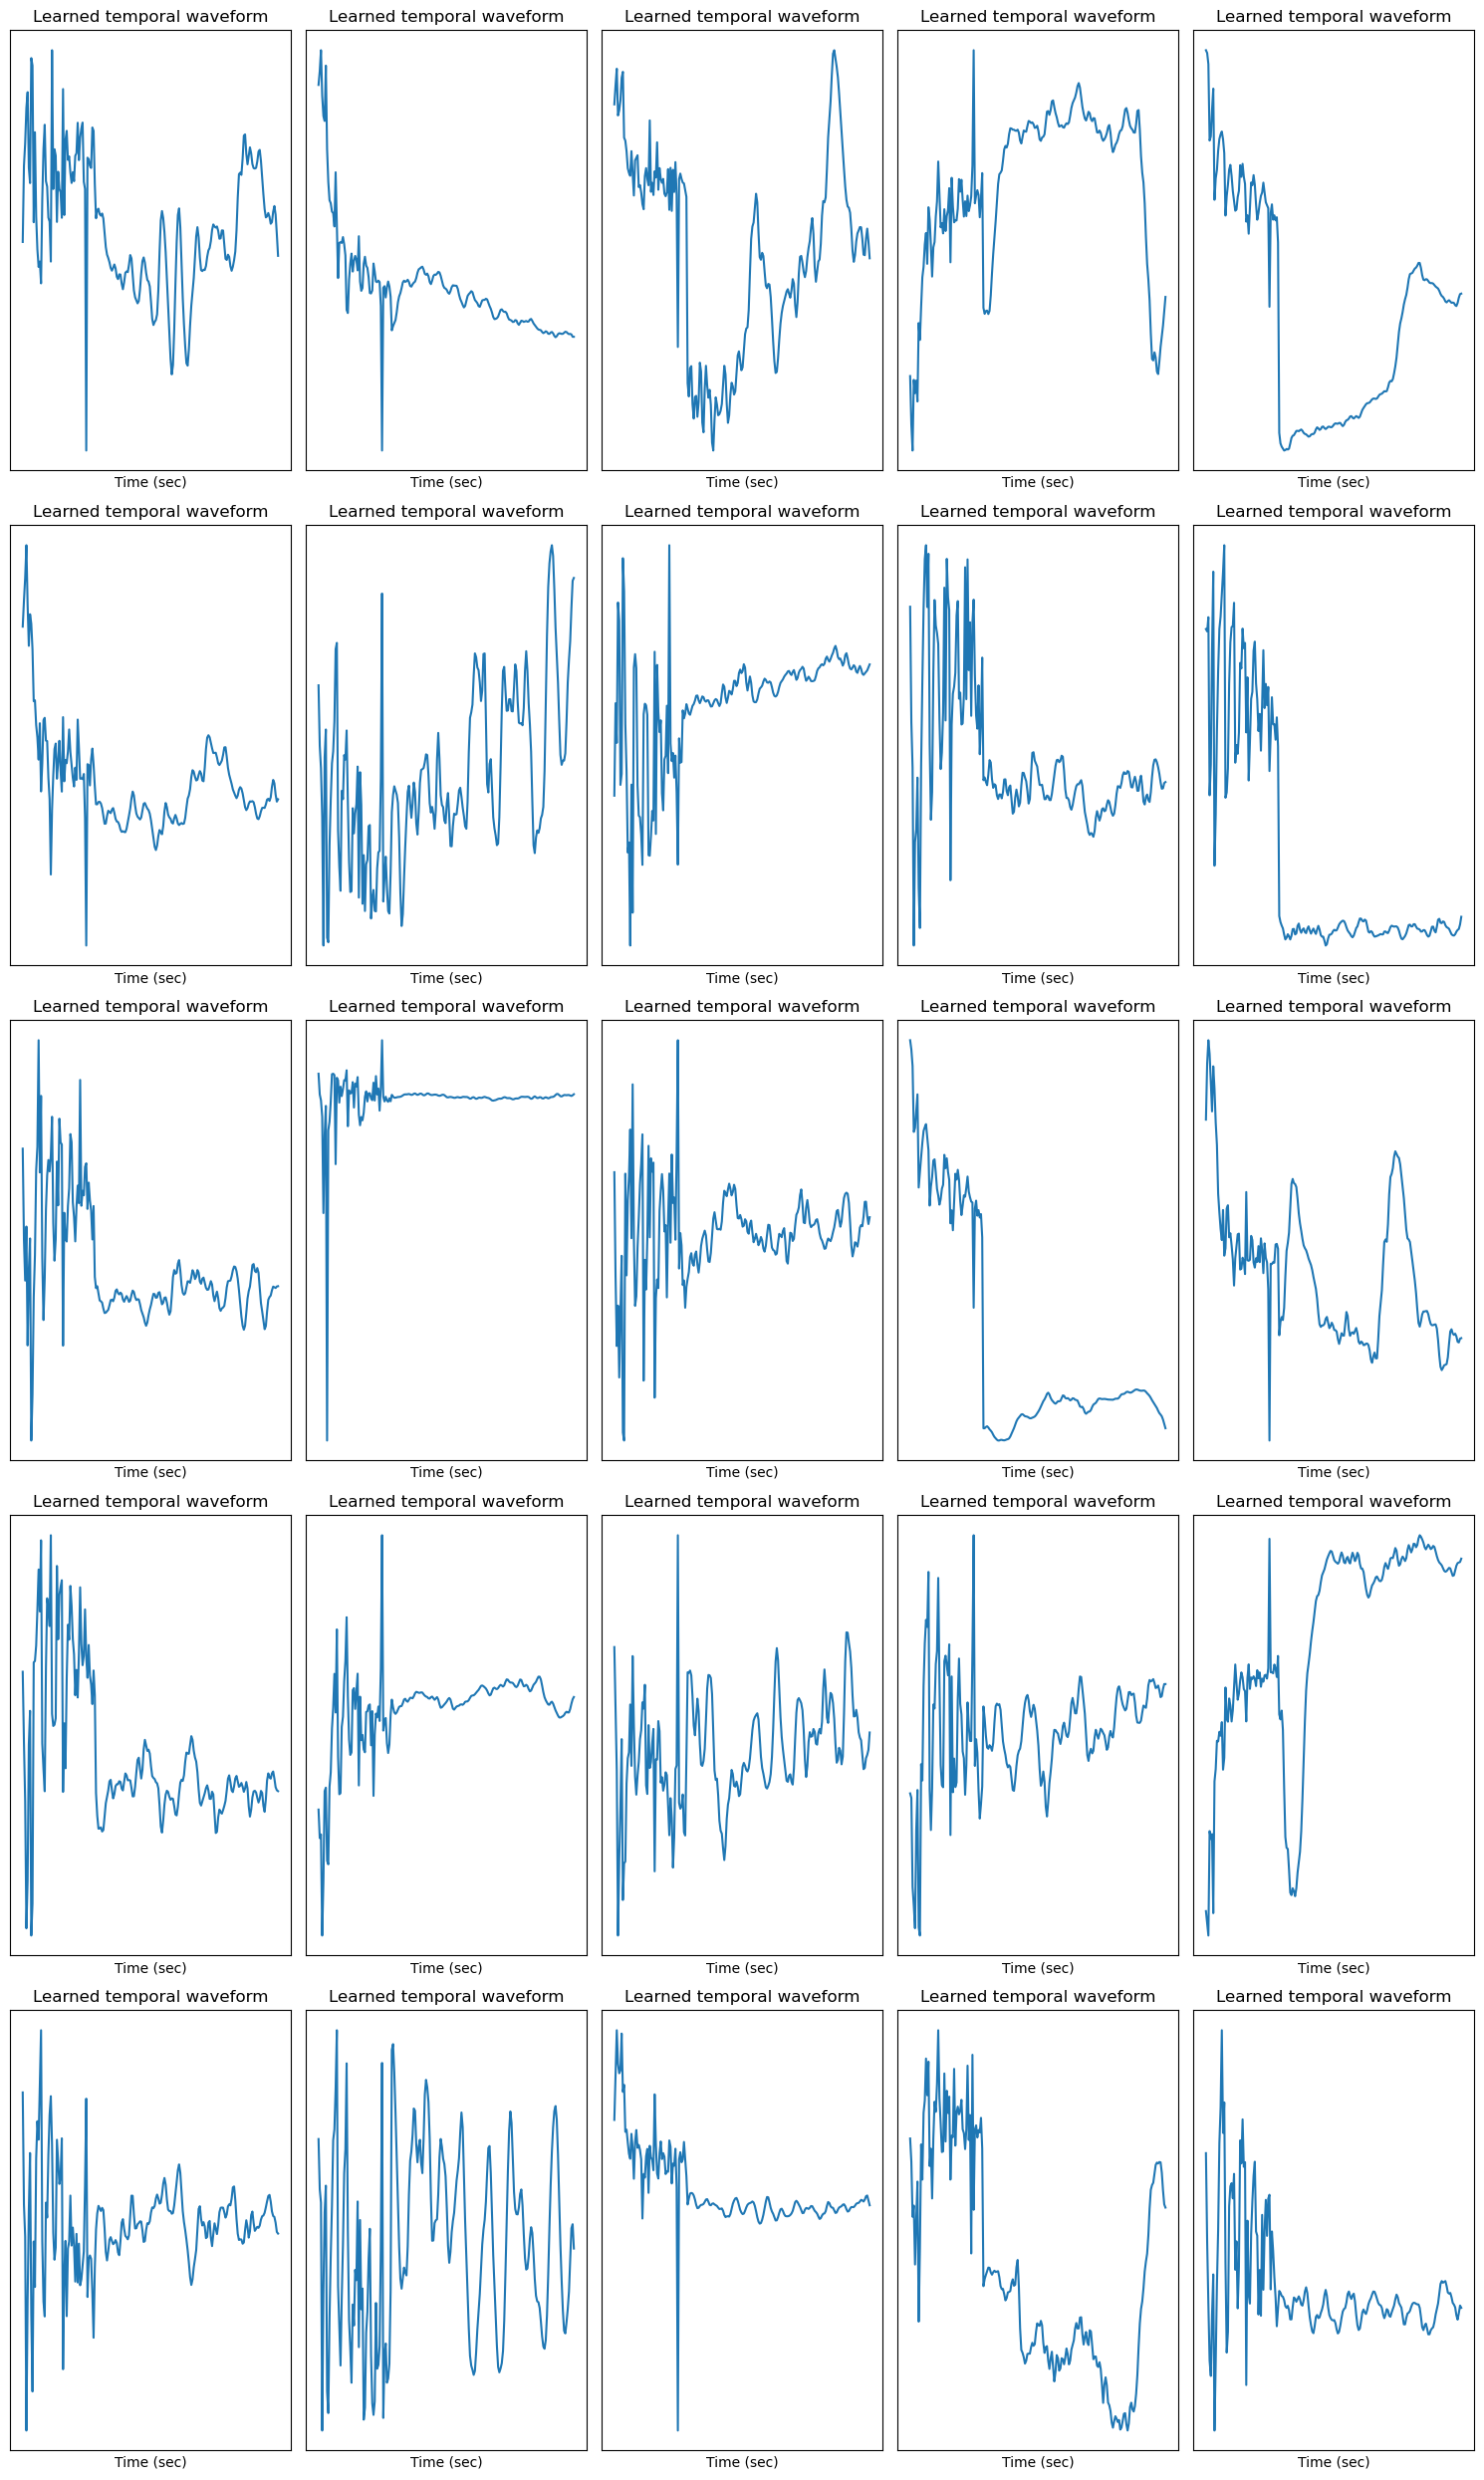

In [298]:
plot_pattern(D=MEG_CDL.uv_hat_, n_cols=5, n_atoms=25, vmax=None, vmin=None, suptitle=None) # MEG

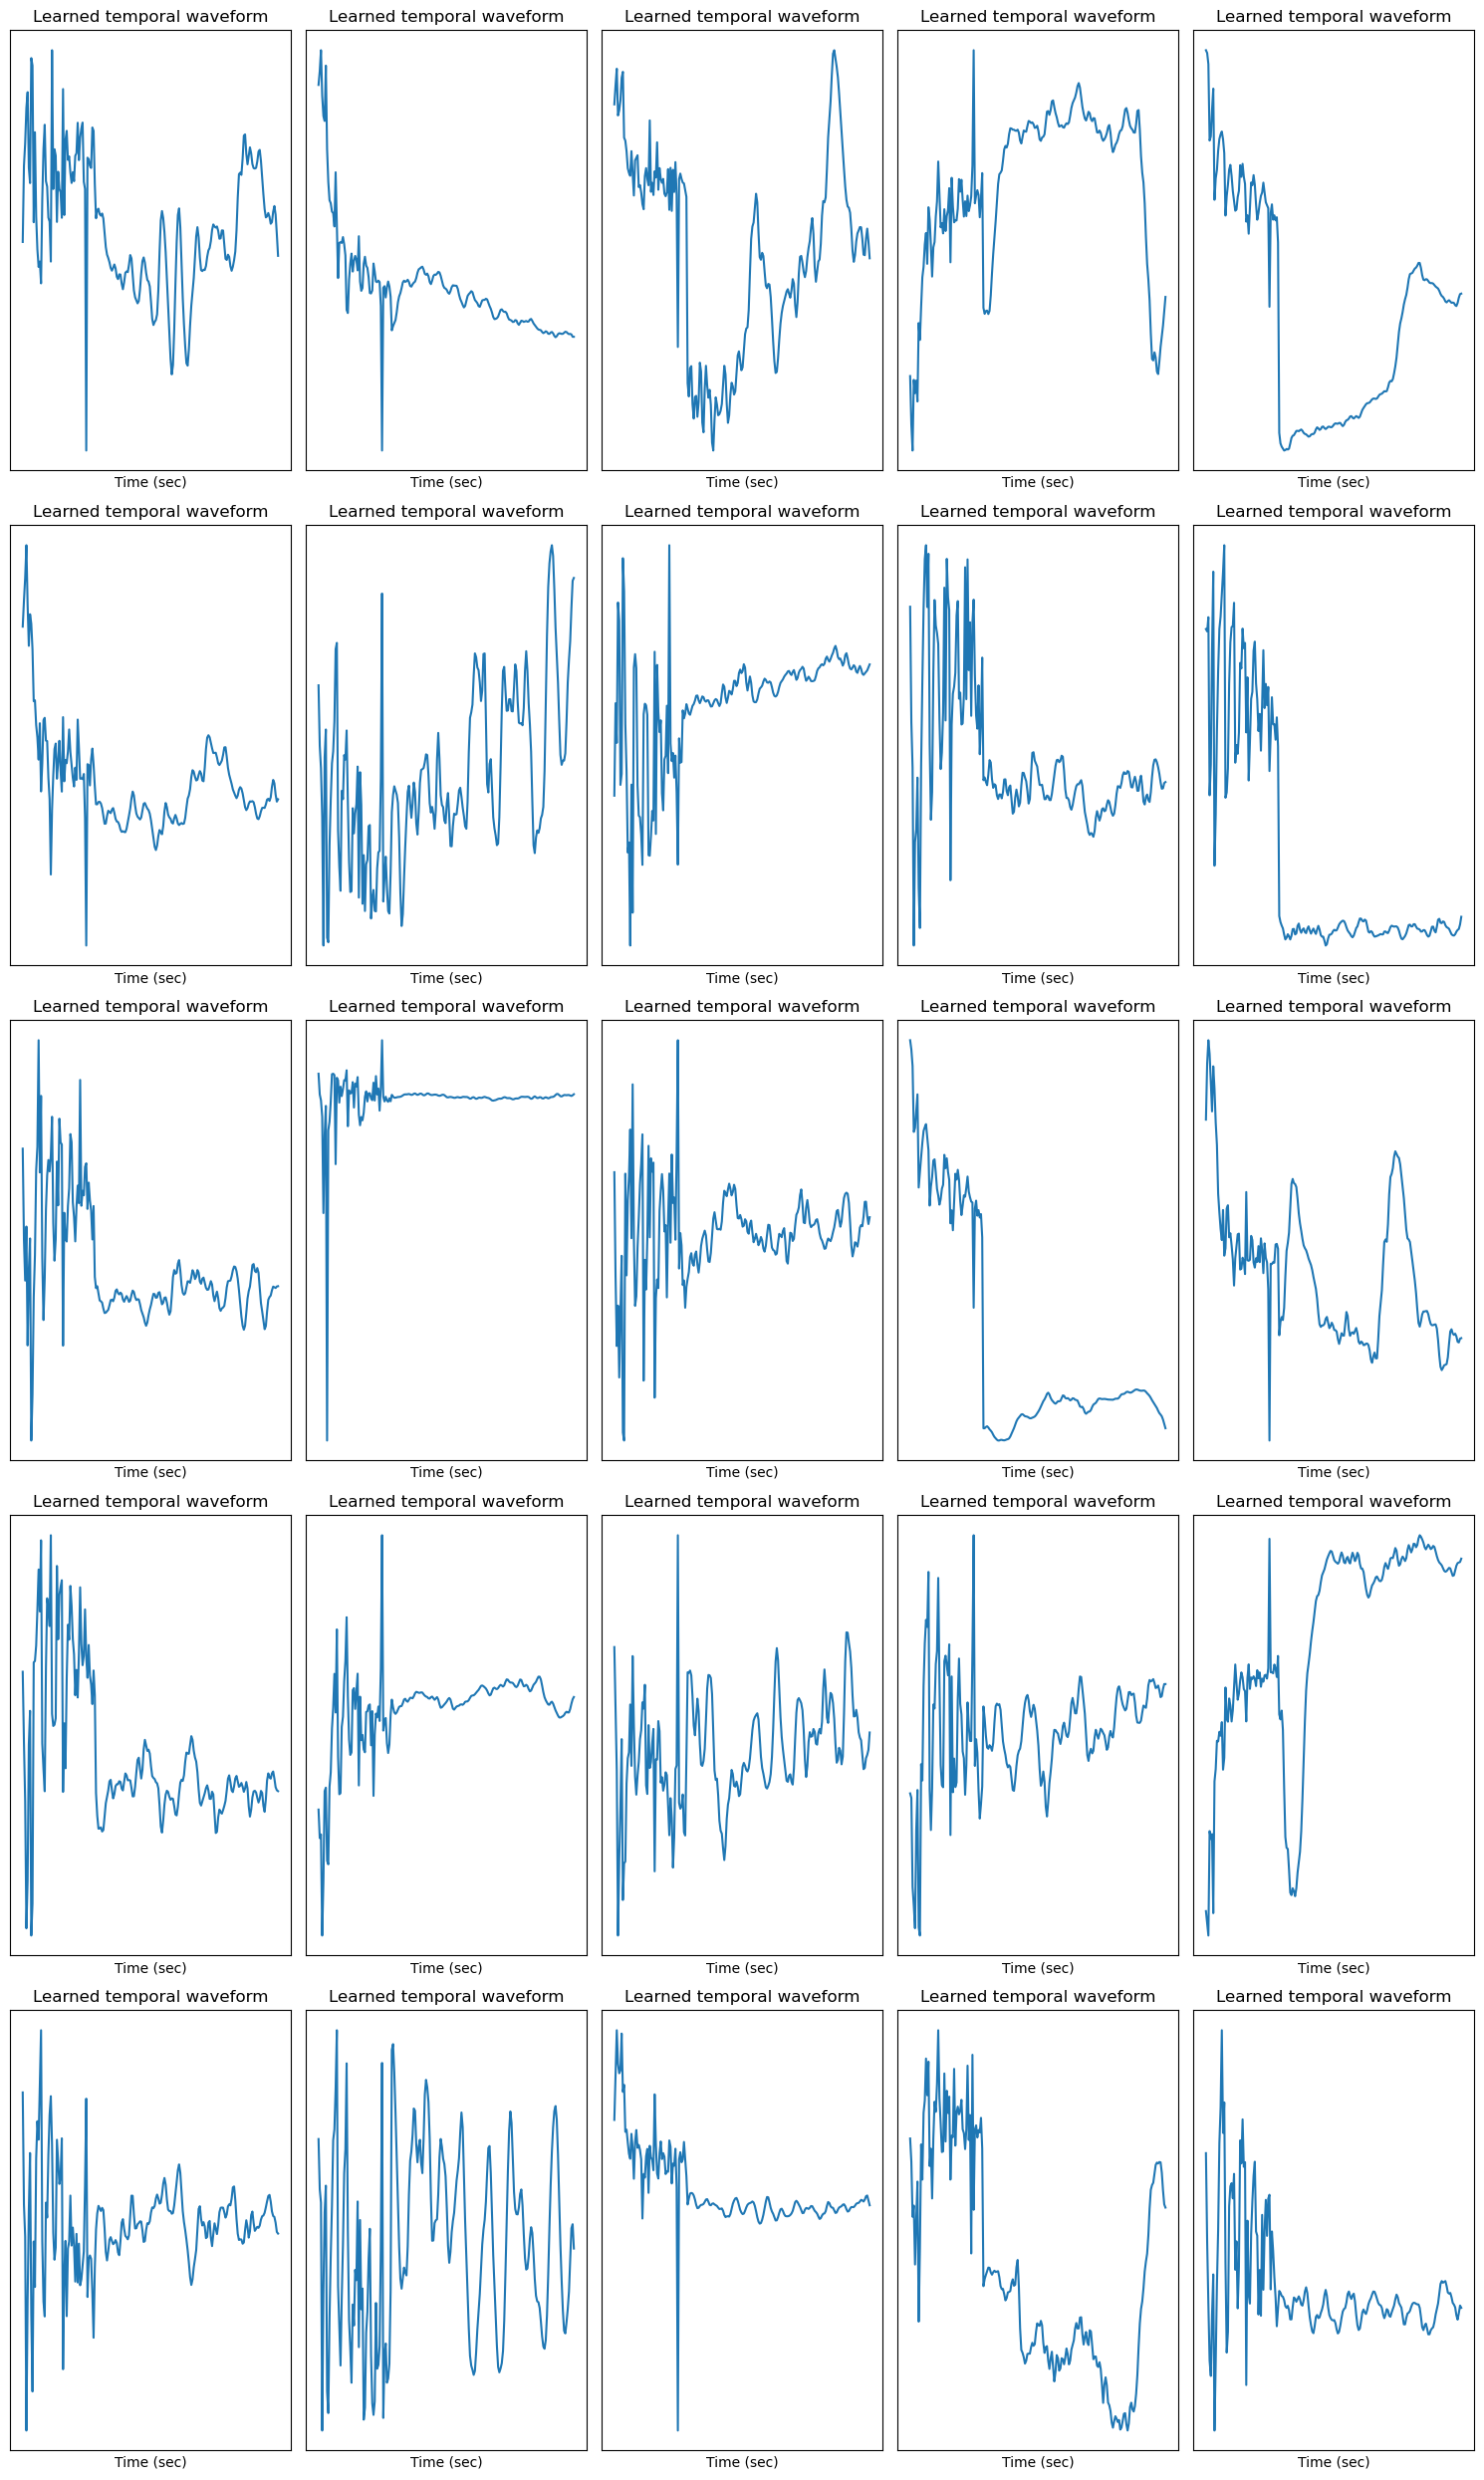

In [299]:
plot_pattern(D=EEG_CDL.uv_hat_, n_cols=5, n_atoms=25, vmax=None, vmin=None, suptitle=None) # EEG

In [300]:
def plot_psd(D, n_cols=5, n_atoms=25, vmax=None, vmin=None, suptitle=None):
    """Plot the temporal pattern of the learn atom"""
    n_rows = int(np.ceil(n_atoms / float(n_cols)))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows),
                             subplot_kw={'xticks': (), 'yticks': ()})
    axes = axes.ravel()
    for ii in range(n_atoms):
        psd = np.abs(np.fft.rfft(D[ii])) ** 2 
        frequencies = np.linspace(0, sfreq / 2.0, len(psd))
        axes[ii].semilogy(frequencies, psd)
        axes[ii].set(xlabel='Frequencies (Hz)', title='Power Spectral Density')
        axes[ii].grid(True)
        axes[ii].set_xlim(0, 30)
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=20)
    fig.tight_layout()
    return fig

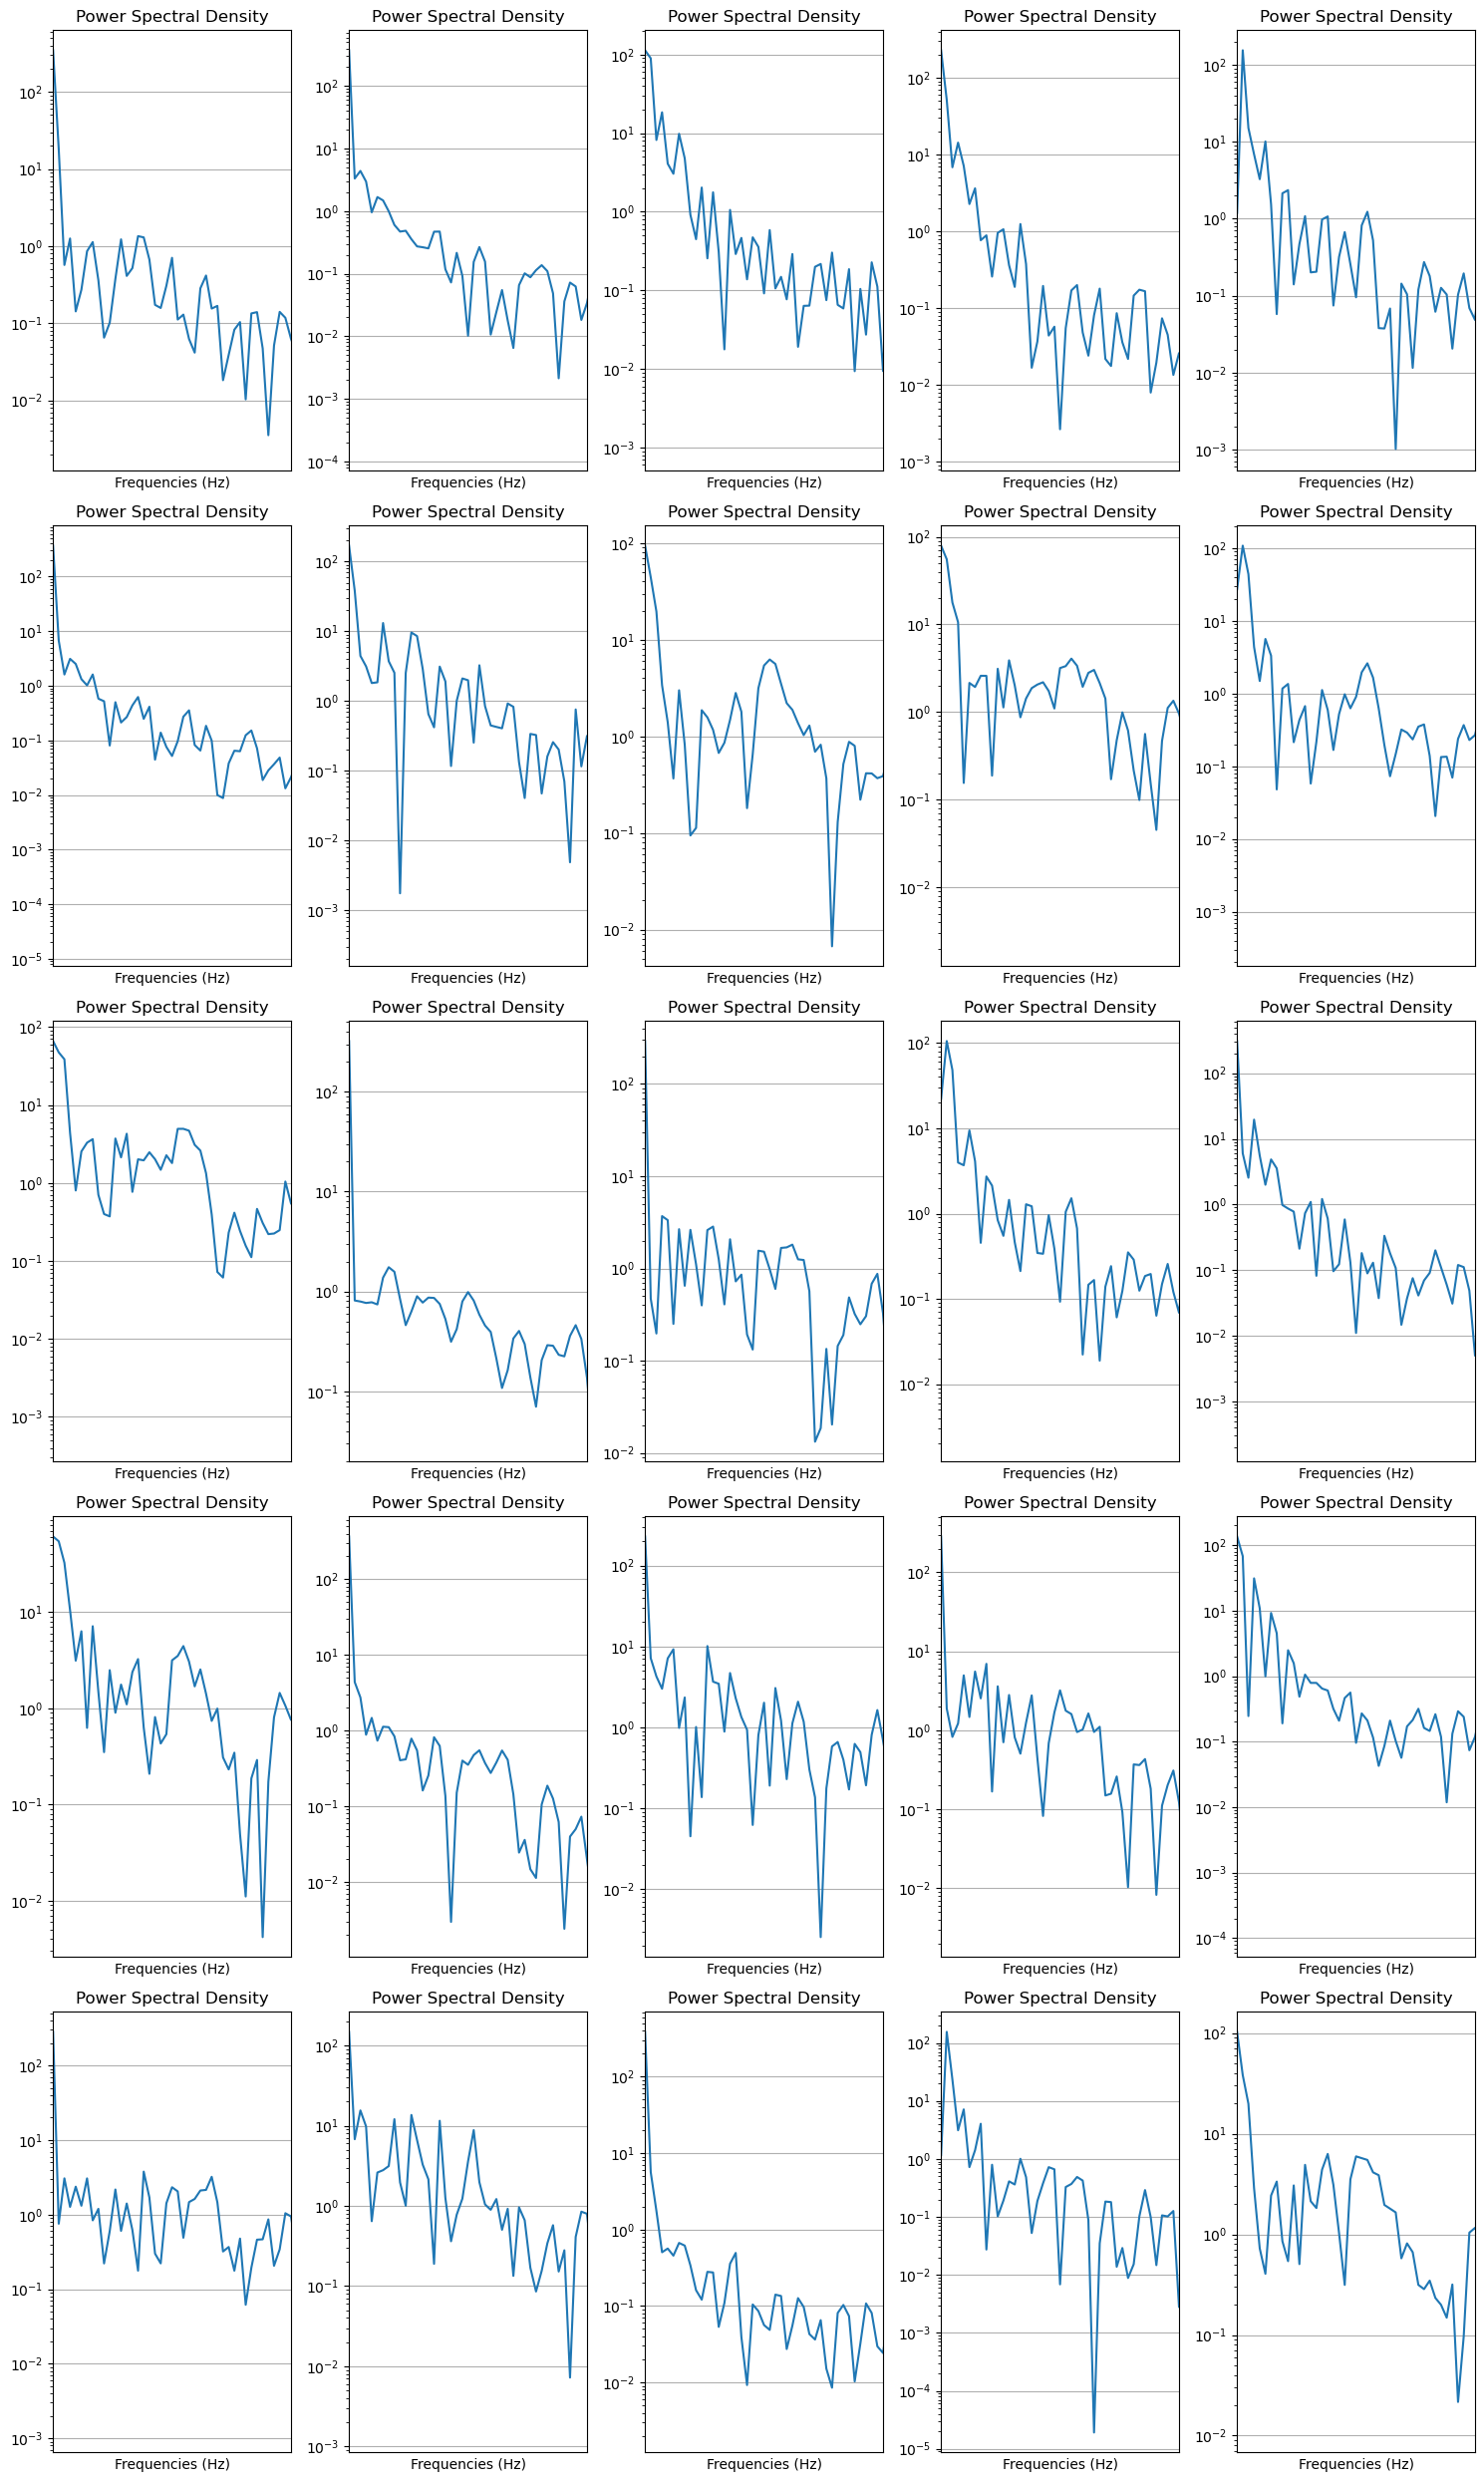

In [301]:
plot_psd(D=MEG_CDL.uv_hat_, n_cols=5, n_atoms=25, vmax=None, vmin=None, suptitle=None) # MEG

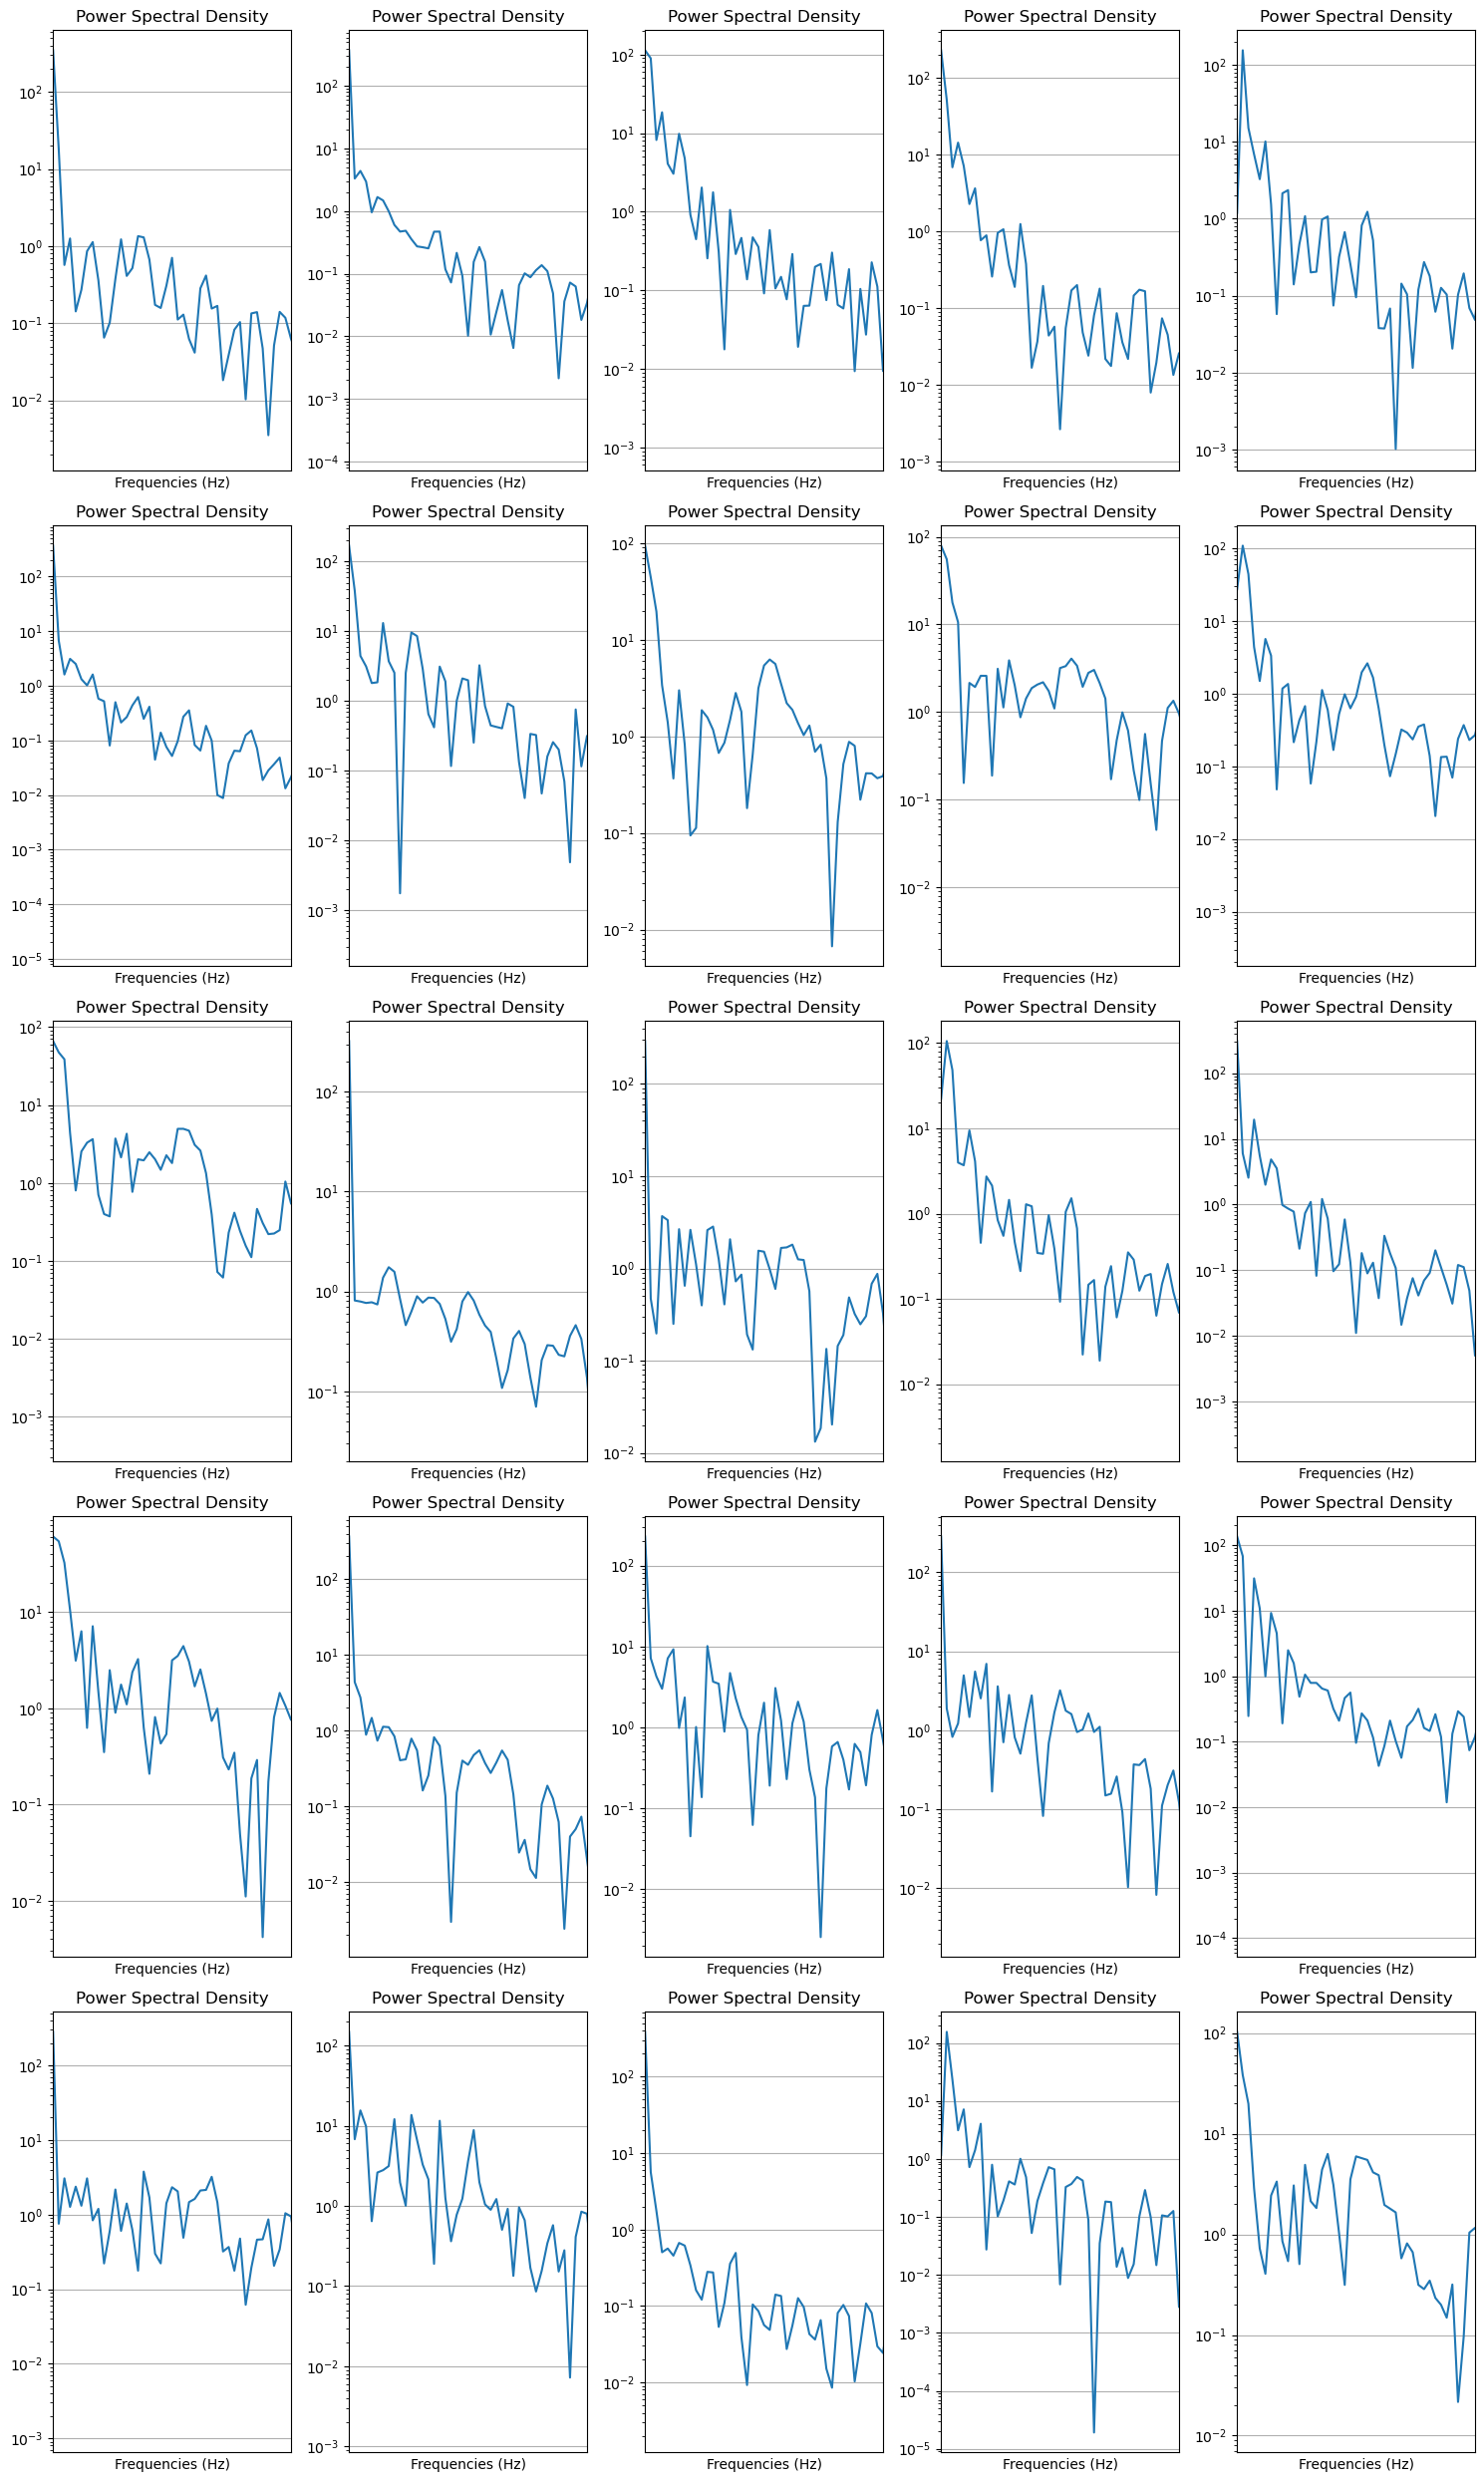

In [302]:
plot_psd(D=EEG_CDL.uv_hat_, n_cols=5, n_atoms=25, vmax=None, vmin=None, suptitle=None) # EEG

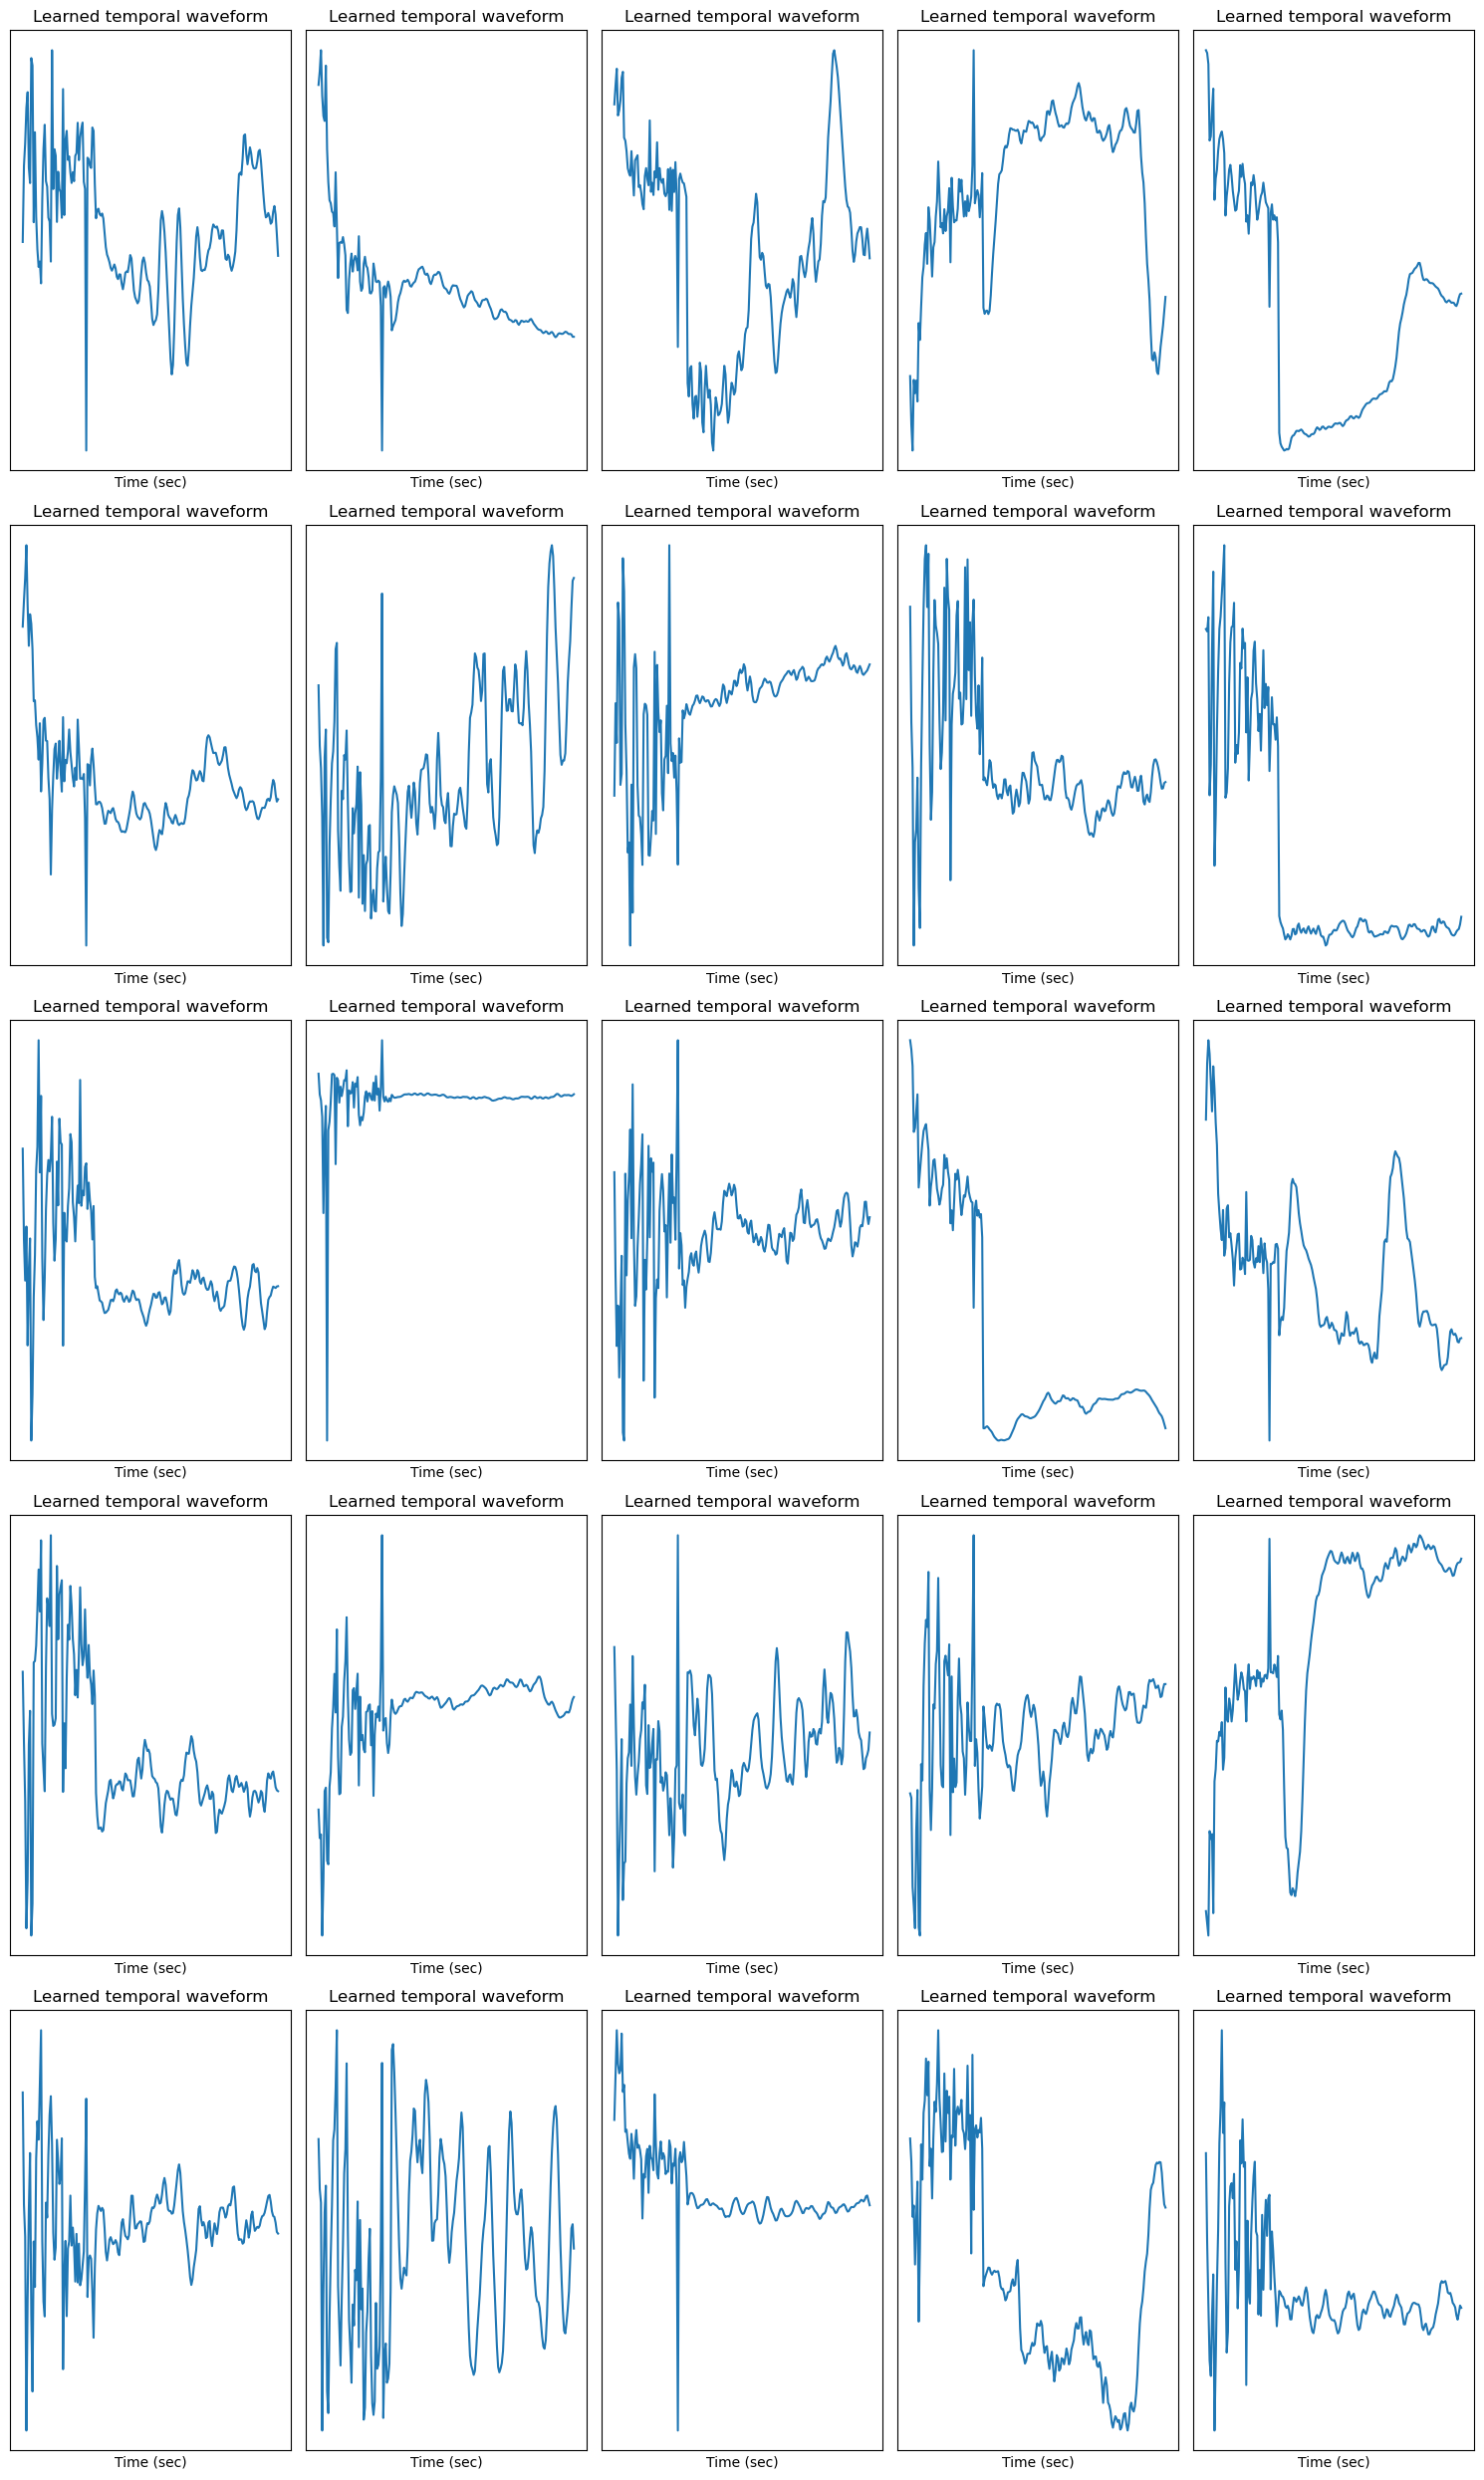

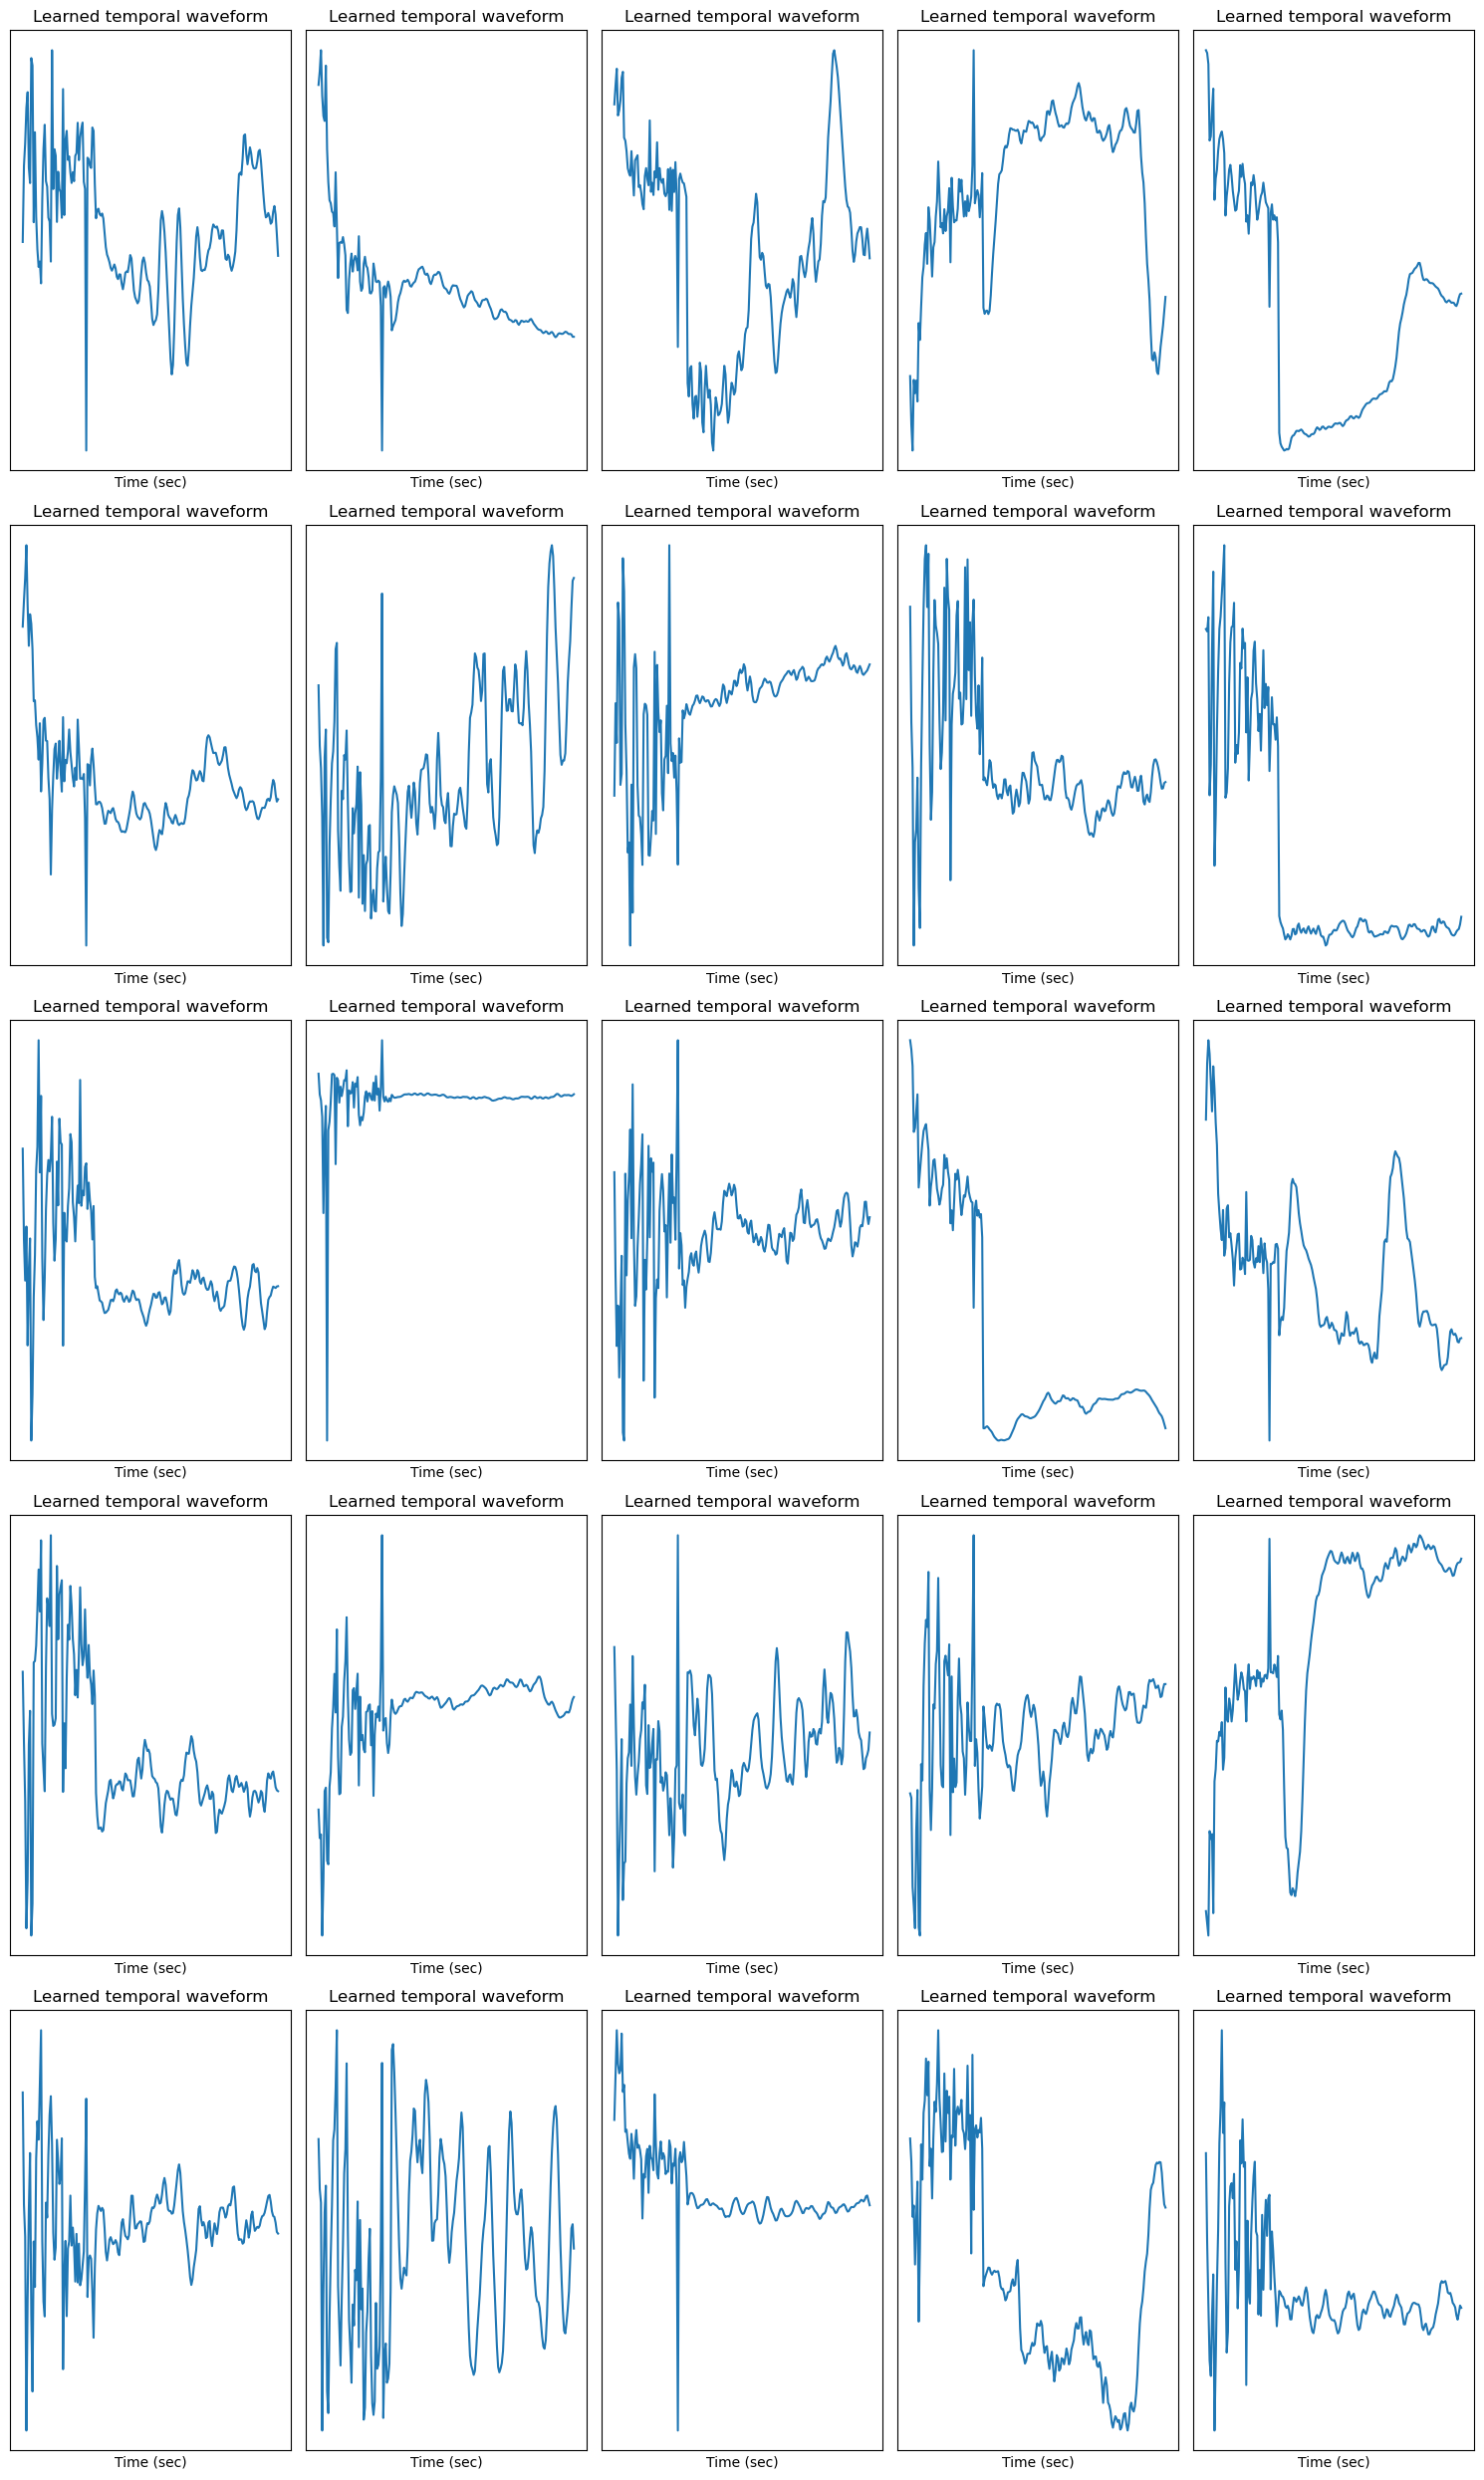

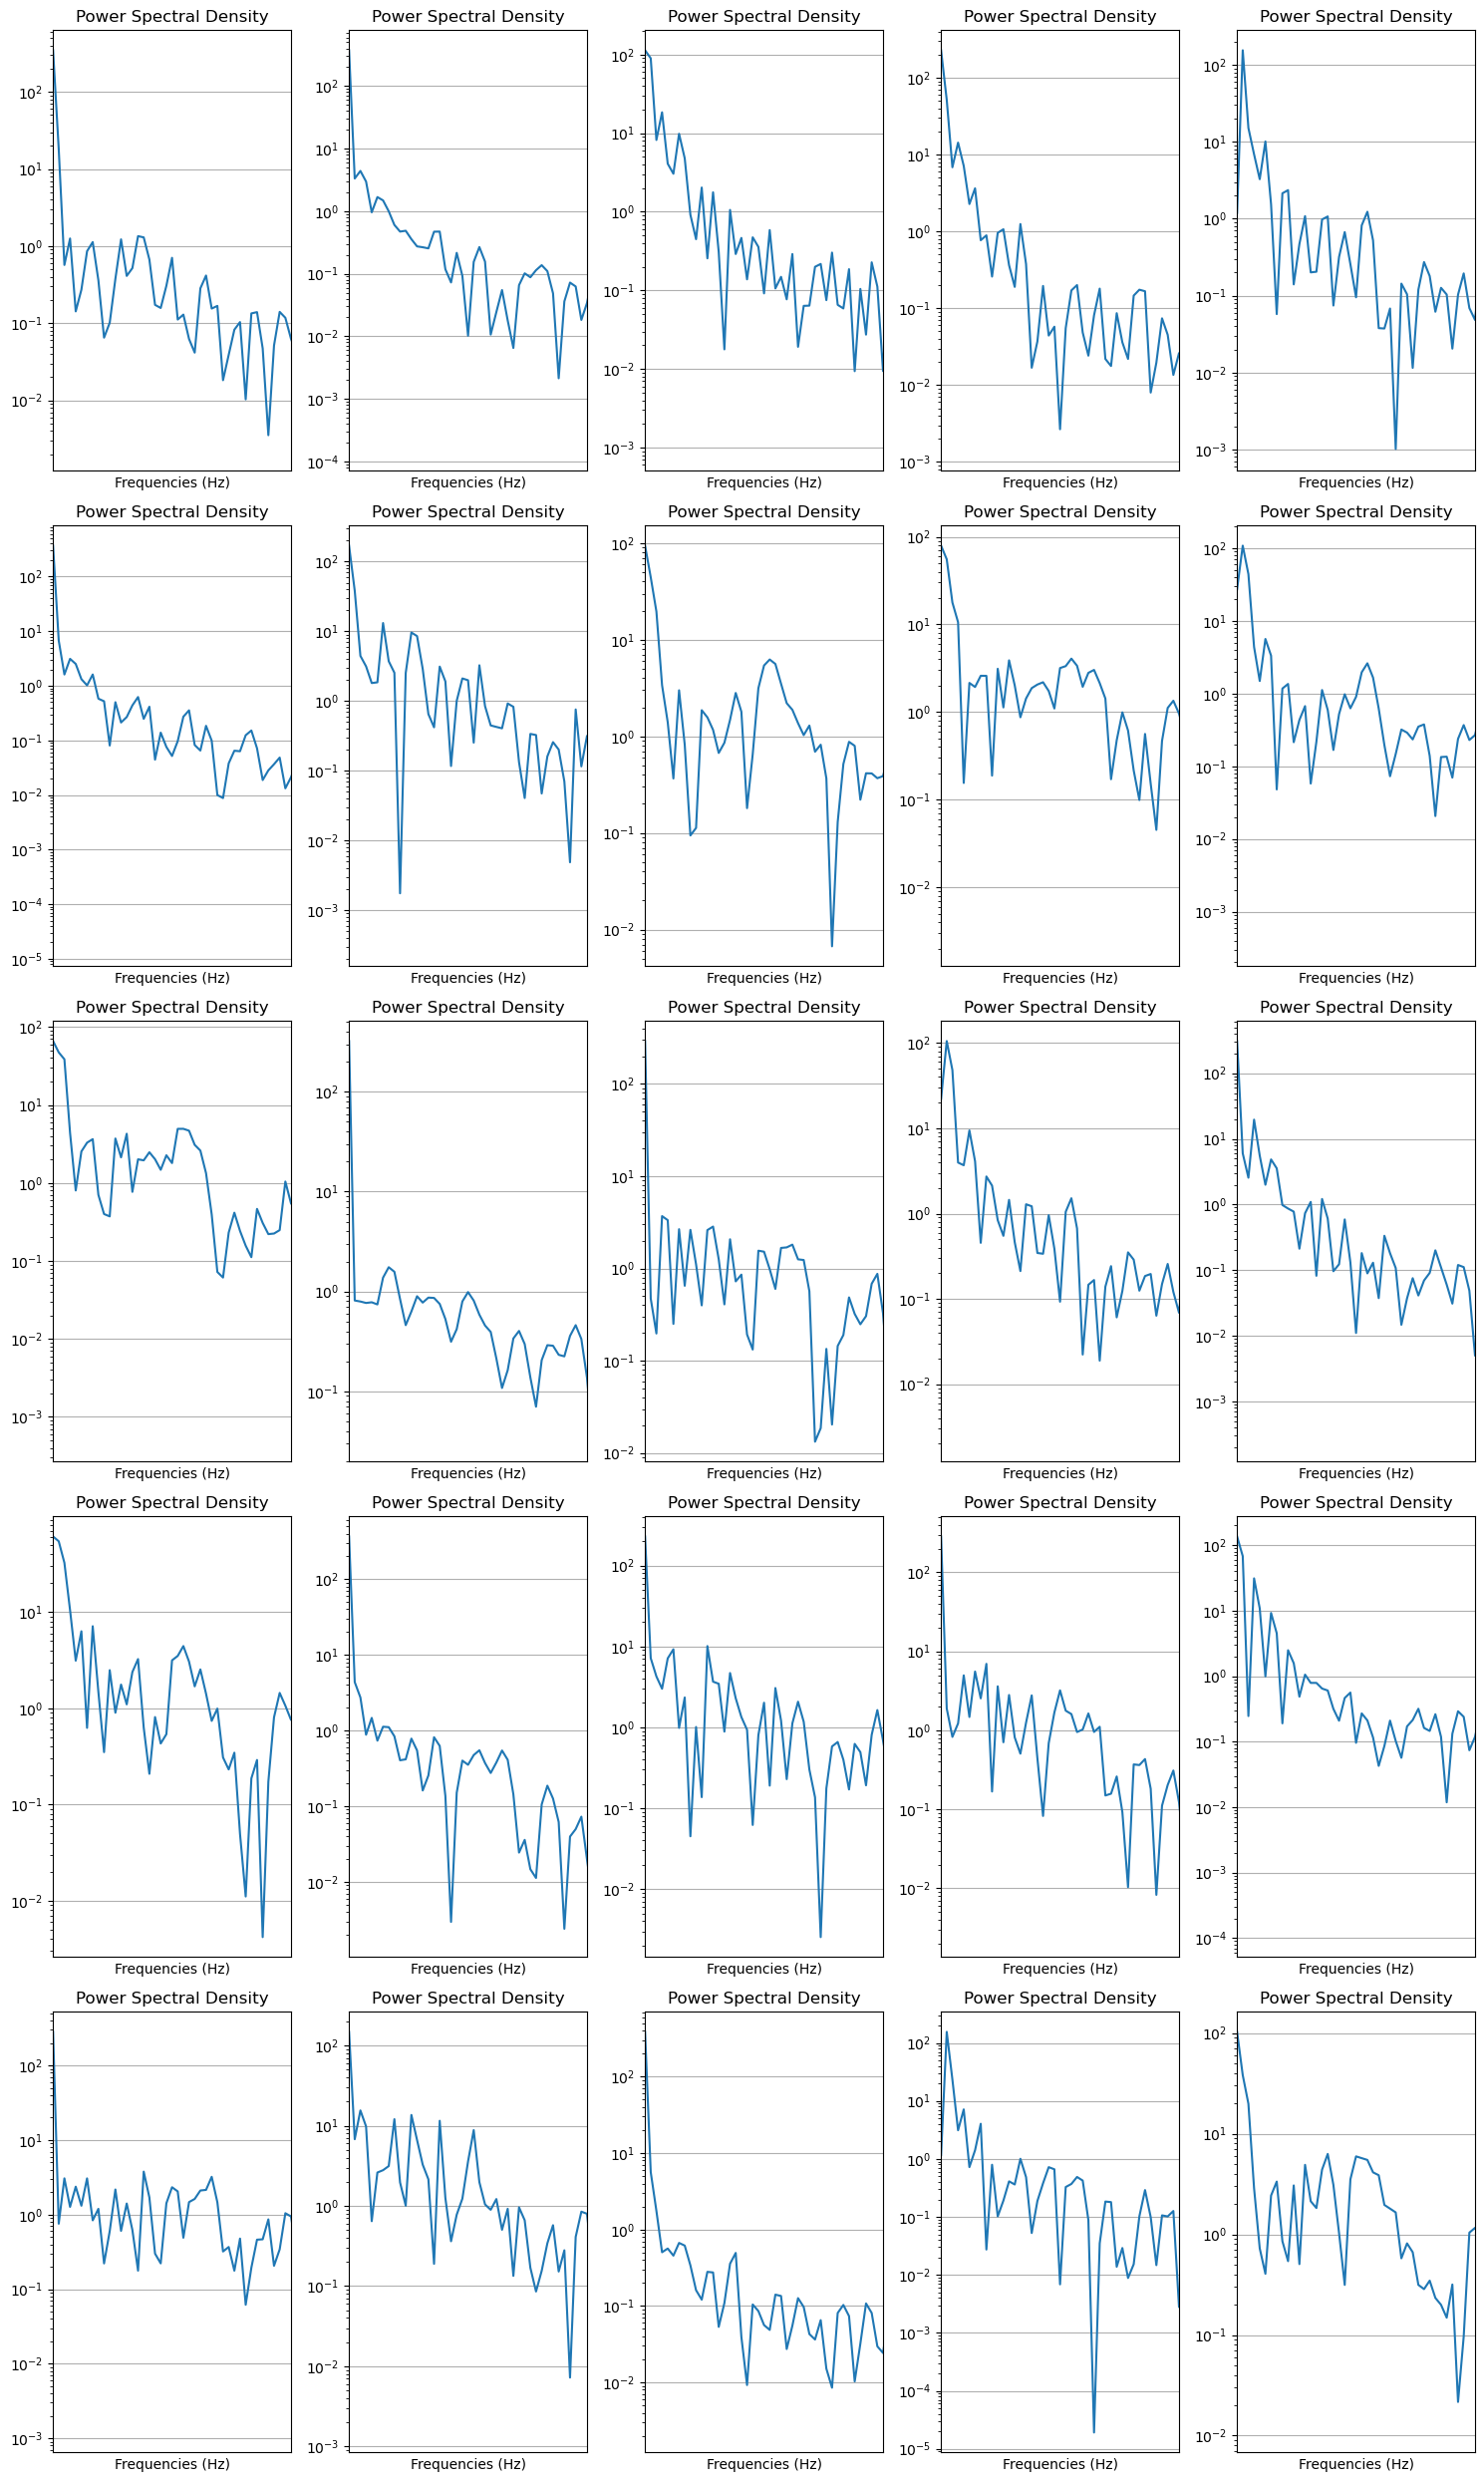

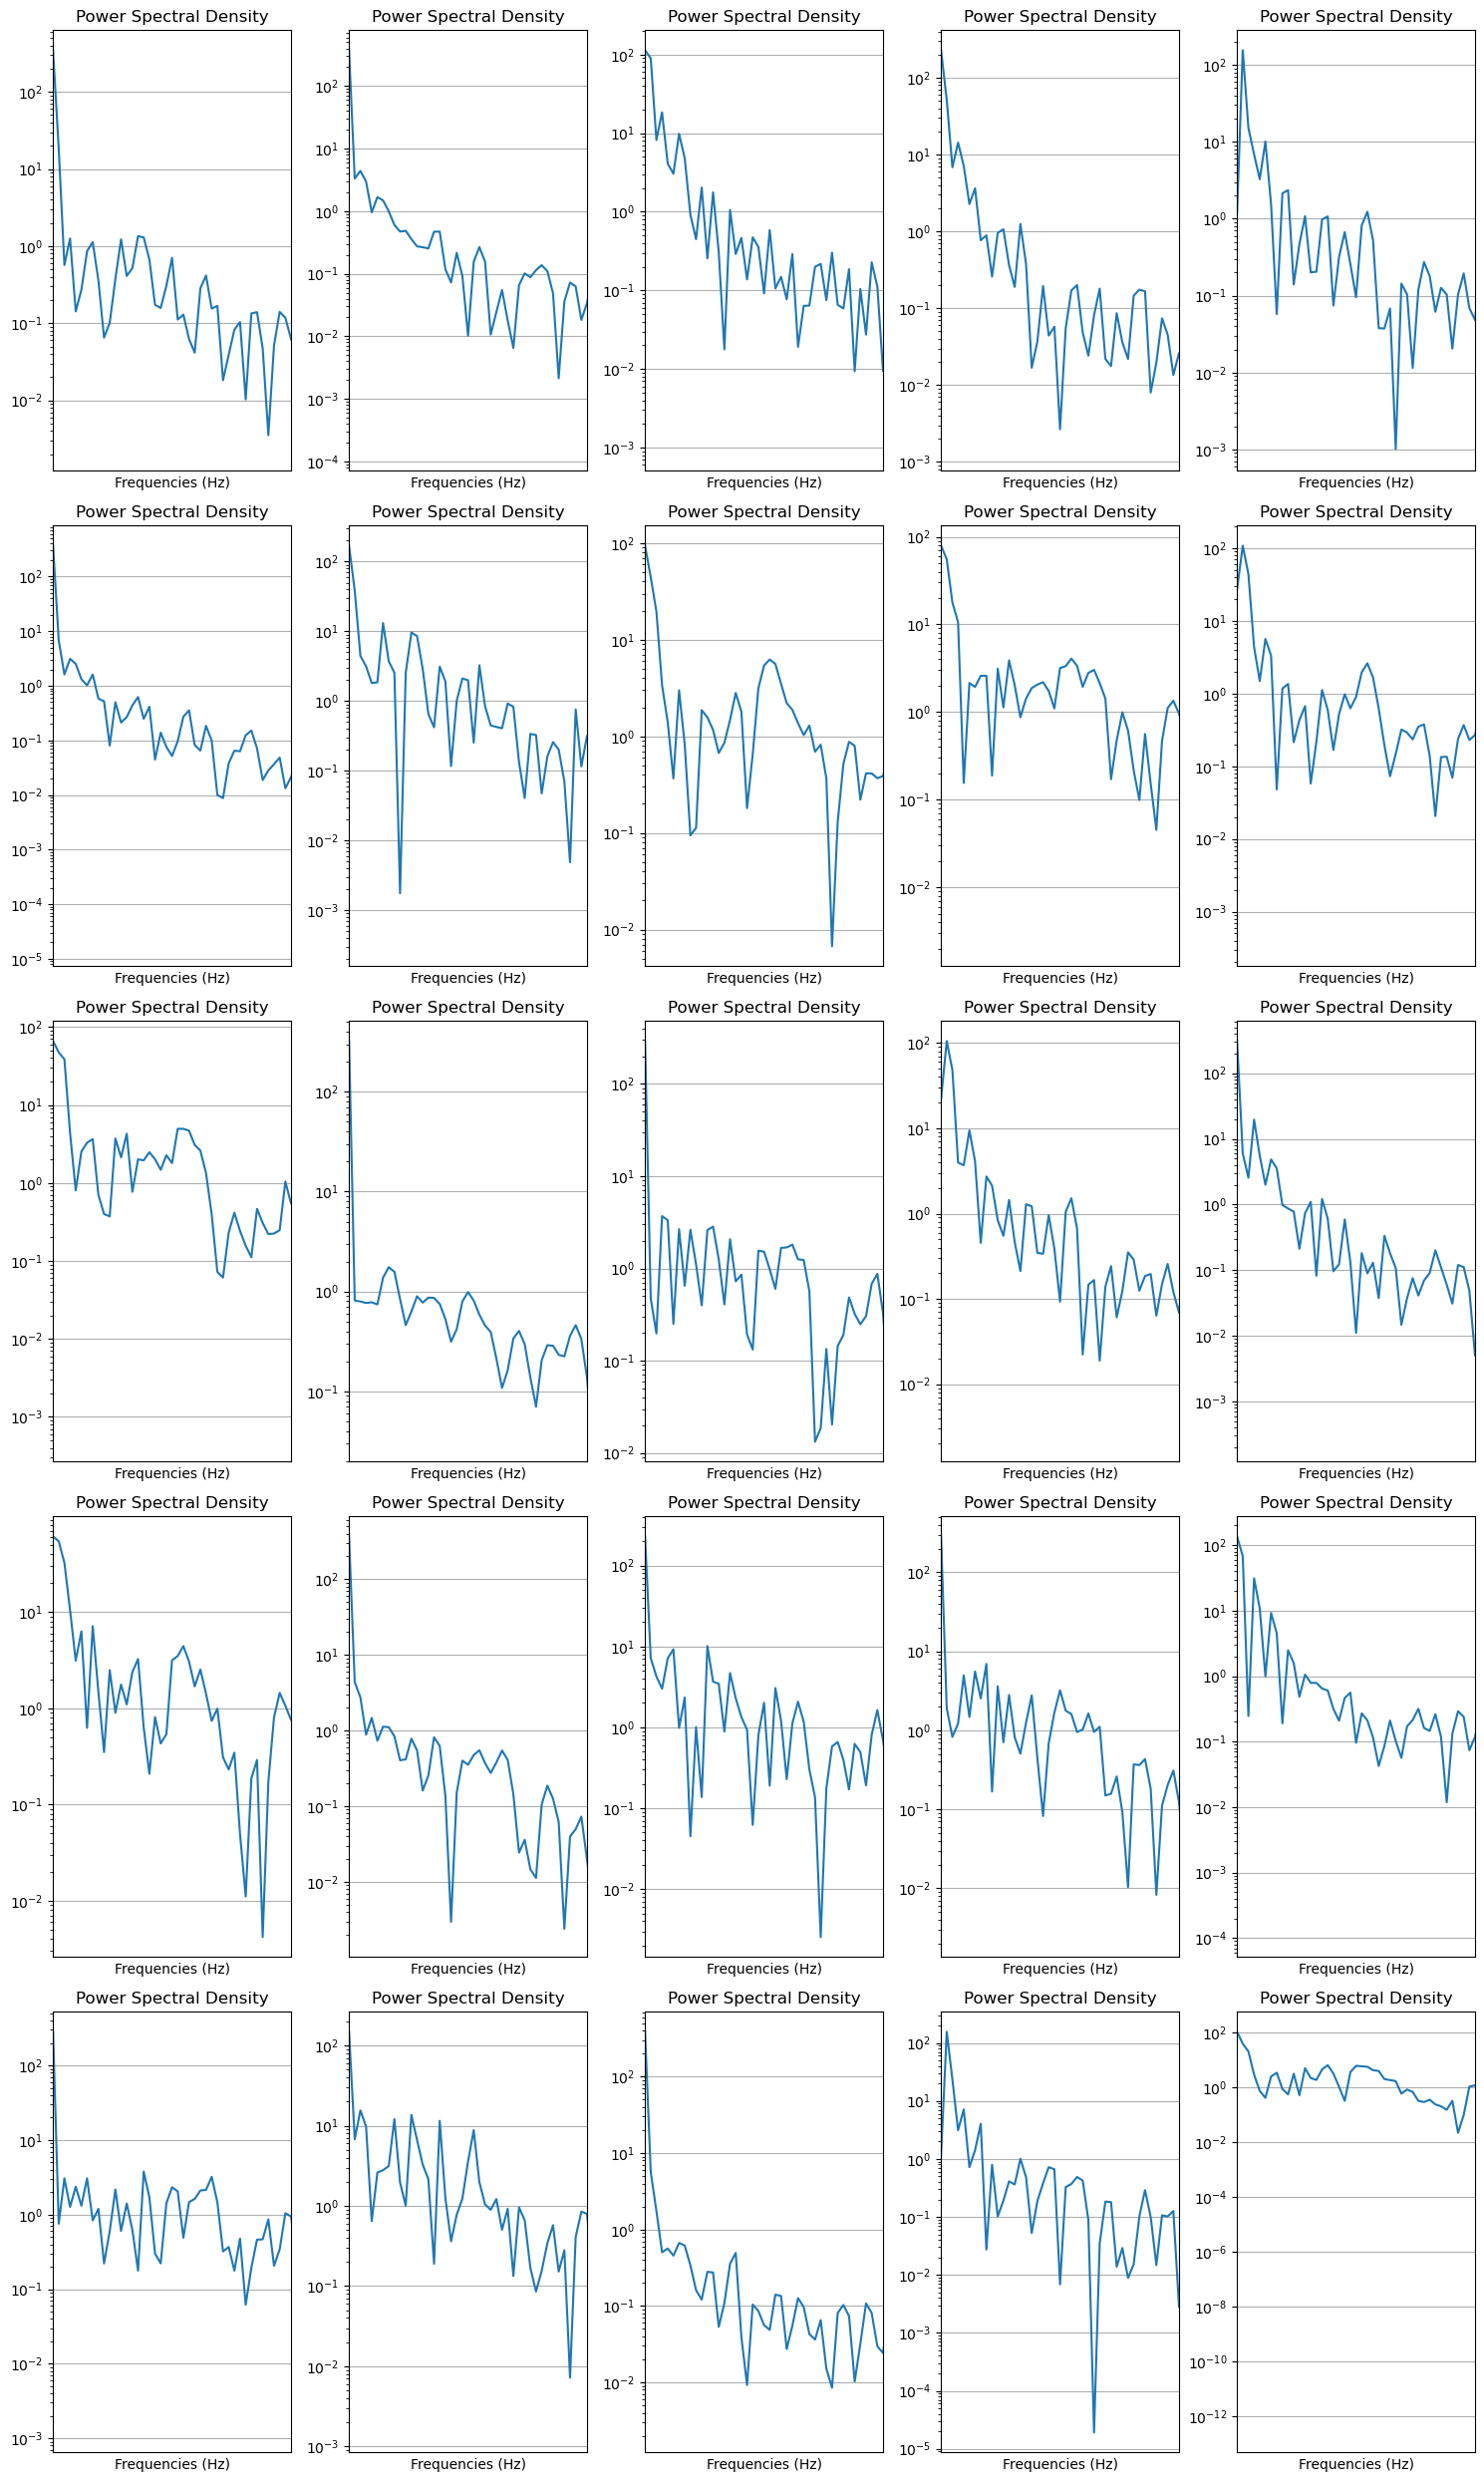

In [303]:
plt.plot(MEG_reshaped[:, 0, :][0][0:1000])
plt.show()

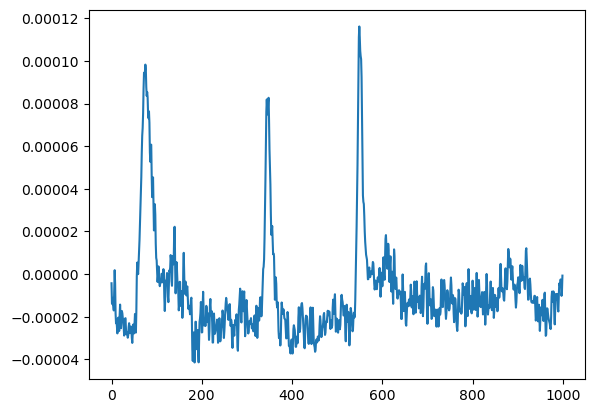

In [304]:
plt.plot(EEG_reshaped[:, 0, :][0][0:1000])
plt.show()

In [305]:
import numpy as np

def matching_pursuit(signal, dictionary):
    coefficients = []
    residual = signal.copy()
    
    while np.linalg.norm(residual) > 0.01:
        best_atom = None
        best_coefficient = None
        best_error = np.inf
        
        for atom in dictionary:
            coefficient = np.dot(residual, atom) / np.linalg.norm(atom)
            error = np.linalg.norm(residual - coefficient * atom)
            
            if error < best_error:
                best_atom = atom
                best_coefficient = coefficient
                best_error = error
        
        coefficients.append(best_coefficient)
        residual -= best_coefficient * best_atom
    
    return coefficients


In [117]:
def phi(L,k):
	us = np.arange(0, 2*L)
	ret = np.sin((us + .5)*np.pi/(2*L))*np.sqrt(2/L)*np.cos( np.pi/L * (us + (L+1)/2)*(k+.5))
	return ret/np.linalg.norm(ret)

def matching_pursuit(s, K, verbose = 0):
    """ Implementation of Matching Pursuit algorithm

    Parameters
    ----------
    s : ndarray
        Signal to apply MP on
    K : int
        Number of iterations

    Returns
    -------
    (ndarray, ndarray)
        (dictionary, coeffs) the learnt dictionary and asociated coefficients
    """
    Ls= [32, 64, 128, 256, 512, 1024]
    signal = s.copy()

    # Return variables
    d_select = []
    coeffs = []
    residuals = []

    # Compute convolutions with atoms to get scalar products with all shifted atoms
    D = np.array([np.pad(phi(L,k), (0,2048 - 2*L)) for L in Ls for k in range(L//2)])

    for i in range(K):
        # Compute best inner product
        scalar_products = abs(np.array([np.convolve(signal, d[::-1]) for d in D]))
        argmax = np.unravel_index(scalar_products.argmax(), scalar_products.shape)

        # Select the best atom (shifted) and coefficients
        d_star = np.roll(D[argmax[0]], argmax[1])
        z_star = signal@d_star

        # Compute residual
        signal = signal - z_star*d_star

        d_select.append(d_star)
        coeffs.append(z_star)
        residuals.append(signal)

        if verbose:
            print("Iteration", i, "Residual norm:", np.linalg.norm(signal))
    return np.array(d_select), np.array(coeffs), np.array(residuals)

In [118]:
import time
t = time.time()
d, coefs, residuals = matching_pursuit(MEG_reshaped2, 25, verbose = 1)
print("Execution time", time.time()-t)

ValueError: object too deep for desired array

In [97]:
matching_pursuit(MEG_reshaped, MEG_CDL.uv_hat_) 

[]